In [313]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Functions for Preprocessing & Scaling Data

In [314]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Run the code again to define and test the Min-Max scaling functions
# Define the function for Min-Max scaling
def min_max_scaling(data):
    """
    Normalize the data using Min-Max scaling.
    Args:
    - data (DataFrame): The data to normalize

    Returns:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column
    """
    scaling_params = {}
    normalized_data = data.copy()

    for column in data.columns:
        min_val = data[column].min()
        max_val = data[column].max()
        scaling_params[column] = {'min': min_val, 'max': max_val}
        normalized_data[column] = (data[column] - min_val) / (max_val - min_val)

    return normalized_data, scaling_params

# Define the function for inverse Min-Max scaling
def inverse_min_max_scaling(normalized_data, scaling_params):
    """
    Reverse the Min-Max scaling to get the original data.
    Args:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column

    Returns:
    - original_data (DataFrame): The data in its original scale
    """
    original_data = normalized_data.copy()

    for idx, column in enumerate(normalized_data.columns):
        # Convert integer column names to string to match with scaling_params keys
        key = str(column) if isinstance(column, int) else column
        keys = list(scaling_params.keys())
        min_val = scaling_params[keys[int(key)]]['min']
        max_val = scaling_params[keys[int(key)]]['max']
        original_data[int(column)] = normalized_data[int(column)] * (max_val - min_val) + min_val
        original_data = original_data.applymap(lambda x: max(0, x))

    return original_data

# Outlier Handling Functions

**Replace outliers for each weekday and each time slot with median for that slot and weekday**

In [315]:
def outlier_handler(data):
    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Extract day of the week and time from the 'date' column
    data['day_of_week'] = data['date'].dt.day_name()
    data['time'] = data['date'].dt.time

    # Define a function to replace outliers with median for each group
    def replace_outliers(group):
        # Iterate over each column in the group
        for col in group.columns:
            if col not in ['date', 'day_of_week', 'time']:
                # Compute the IQR
                Q1 = group[col].quantile(0.25)
                Q3 = group[col].quantile(0.75)
                IQR = Q3 - Q1

                # Define bounds for outliers
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                # Replace outliers with median of the group
                median_val = group[col].median()
                group[col] = group[col].apply(lambda x: median_val if x < lower_bound or x > upper_bound else x)

        return group

    # Group by 'day_of_week' and 'time' and apply the function to replace outliers
    data = data.groupby(['day_of_week', 'time']).apply(replace_outliers)
    data = data.drop(columns=['day_of_week','time'])

    return data.reset_index().iloc[:,3:-1]

# Function for Handling Zero Points

In [316]:
def zero_handler(data, range):
    data['date'] = pd.to_datetime(data['date'])
    data['weekday'] = data['date'].dt.dayofweek
    data['time'] = data['date'].dt.time

    # Loop over each segment column
    for col in data.columns[3:-2]:
        # Group by weekday and time slot
        grouped = data.groupby(['weekday', 'time'])

        # Define a function to apply to each group
        def replace_zeros(group):
            nonzero_mean = group[group != 0].mean()
            if pd.notnull(nonzero_mean):
                return group.replace(0, nonzero_mean)
            else:
                return group

        # Apply the function to each group in the specific segment column
        data[col] = grouped[col].transform(replace_zeros)

    data = data.drop(columns=['weekday','time'])

    return data

In [317]:
def handle_zeros_with_rolling_mean(data, range_num):
    for col in data.columns[1:]:
        mv_avg = data[col].rolling(range_num).mean()

        for i in range(range_num,len(data[col])):
            data.loc[i-range_num:i+1,col].mean()

        for i, val in enumerate(data[col]):
            if val == 0:
                data.loc[i,col] = mv_avg[i]
    data = data.tail(-(range_num))
    return data

In [318]:
import math

# range_num = 18
# col = '5'

def fill_zeros_median(data, range_num):
    for col in data.columns[1:]:
        for i in range(range_num-1, len(data)):
            if data.loc[i,col] == 0:
                avg = data.loc[i-range_num:i+1,col].loc[data.loc[i-range_num:i+1,col] != 0 ].median()
                if math.isnan(avg):
                    avg = data.loc[i-range_num:i+range_num,col].loc[data.loc[i-range_num:i+range_num,col] != 0 ].median()
                    if math.isnan(avg):
                        # avg = data.loc[:,col].loc[data.loc[:,col] != 0 ].median()
                        avg = 0
                        # if math.isnan(avg):
                        #     avg = data1.loc[i:i+100,'3'].loc[data1.loc[i:i+100,'3'] != 0 ].mean()
                data.loc[i,col] = avg

    return data.tail(-(range_num))



# Function for Moving Average Filter

In [319]:
def moving_avg_filter(data, window):
    # Calculate the 3-period moving average for each column (excluding the 'date' column)
    for col in data.columns:
        if col != 'date':
            data[col] = data[col].rolling(window).mean()


    # Since the first two rows will have NaN values due to the 3-period moving average,
    # fill them using forward fill.
    data.fillna(method='ffill', inplace=True)

    # Replace any remaining NaN values with zero
    data.fillna(0, inplace=True)

    data = data.tail(-(window-1))

    return data

# Function for Converting data into sequential data

**Get a matrix of 8 hour window as X and its next step values as Y**

In [320]:
# def formatting_features_targets(data_values, window_size, step_i):
#     # Preprocessing and reshaping data
#     num_sequences = len(data_values) - window_size
#     X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
#     y = np.array([data_values[i+window_size+step_i-1] for i in range(num_sequences)])
#     X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

#     return X, y

In [321]:
def formatting_features_targets(data_values, window_size, step_i,dates):
    # Preprocessing and reshaping data
    num_sequences = len(data_values) - window_size - step_i
    X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
    y = np.array([data_values[i+window_size:i+window_size+step_i] for i in range(num_sequences)])
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
    d = np.array([dates[i+window_size:i+window_size+step_i] for i in range(num_sequences)])
    y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])

    return X, y, d

# Transformer Model

In [322]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatioTemporalModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, num_encoder_layers, num_decoder_layers, pred_steps, dropout_rate=0.1):
        super(SpatioTemporalModel, self).__init__()

        self.output_size = output_size
        self.pred_steps = pred_steps

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
#         self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
#         self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolutional layers
        self.flattened_size = (input_size[1] // 4) * (input_size[2] // 4) * 32  # Dividing by 4 due to two pooling layers
        # Bottleneck layer to adjust the dimensionality to d_model
        self.bottleneck = nn.Linear(self.flattened_size, d_model)

        # Transformer layers
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_rate
        )

        # Linear layer for prediction
        self.fc1 = nn.Linear(d_model, d_model//2)
        self.fc2 = nn.Linear(d_model//2, d_model//4)
        self.fc3 = nn.Linear(d_model//4, output_size)

    def forward(self, x):
        outputs = []

        for i in range(self.pred_steps):

            # Convolutional layers
            x1 = self.pool1(F.relu(self.conv1(x)))
            x1 = self.pool2(F.relu(self.conv2(x1)))

            # Flattening
            x1 = x1.view(x1.size(0), -1)
            x1 = self.bottleneck(x1)

            # Transformer layers
            x1 = x1.unsqueeze(0)
            x1 = self.transformer(x1, x1)
            x1 = x1.squeeze(0)

            # Linear layer for prediction
            x1 = F.relu(self.fc1(x1))
            x1 = F.relu(self.fc2(x1))
            x1 = self.fc3(x1)

            outputs.append(x1)

            x = x[:, :, 1:, :]
            x1 = x1.unsqueeze(1).unsqueeze(2)
            x = torch.cat((x, x1), dim=2)

        return outputs

# Placing Data into Torch Tensors Functions

In [323]:
def get_torch_tensor(df, device):
    return torch.tensor(df, dtype=torch.float32).to(device)

def get_data_loader(X, y, device, batch_size, shuffle):
    X_tensor = get_torch_tensor(X, device)
    y_tensor = get_torch_tensor(y, device)
    tensor_dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

def get_train_val_test_loaders(X_scaled, y_scaled, val_fraction, test_fraction, device, batch_size,dates_scaled):
    test_splitter = round(len(X_scaled)*(1-test_fraction))
    X_train_val_scaled , X_test_scaled = X_scaled[:test_splitter] , X_scaled[test_splitter:]
    y_train_val_scaled , y_test_scaled = y_scaled[:test_splitter] , y_scaled[test_splitter:]
    dates_train_val_scaled , dates_test_scaled = dates_scaled[:test_splitter] , dates_scaled[test_splitter:]

    train_val_splitter = round(len(X_train_val_scaled)*(1-val_fraction))
    X_train_scaled , X_val_scaled = X_train_val_scaled[:train_val_splitter] , X_train_val_scaled[train_val_splitter:]
    y_train_scaled , y_val_scaled = y_train_val_scaled[:train_val_splitter] , y_train_val_scaled[train_val_splitter:]
    dates_train_scaled , dates_val_scaled = dates_train_val_scaled[:train_val_splitter] , dates_train_val_scaled[train_val_splitter:]
    
    train_loader = get_data_loader(X_train_scaled, y_train_scaled, device, batch_size, True)
    val_loader = get_data_loader(X_val_scaled, y_val_scaled, device, batch_size, False)
    test_loader = get_data_loader(X_test_scaled, y_test_scaled, device, batch_size, False)
    return train_loader, val_loader, test_loader, dates_test_scaled

# Training

In [324]:
def training(model, train_loader, val_loader, pred_steps, patience = 3):
    # Training loop with tqdm progress bar
    criterion = [nn.MSELoss()]*pred_steps
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs = 15
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = []
            for i in range(pred_steps):
                loss.append(criterion[i](predictions[i], y_batch[:, 0, i]))
            loss = sum(loss) / len(loss)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            with torch.no_grad():
                predictions1 = model(X_batch)
                val_loss = []
                for i in range(pred_steps):
                    val_loss.append(criterion[i](predictions1[i], y_batch[:, 0, i]))
                val_loss = sum(val_loss) / len(val_loss)
                total_val_loss += val_loss
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Implement early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping after {epoch + 1} epochs without improvement.")
            break

# Error Metrics Functions

## For Overall

In [325]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluateModel(model, val_loader, device, pred_steps, scaling_params=None):

    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            for i in range(pred_steps):
                all_predictions.extend(predictions[i].cpu().numpy())
                all_true_values.extend(y_batch[:,0,i].cpu().numpy())

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    mse = mean_squared_error(all_true_values, all_predictions)
    rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
    mae = mean_absolute_error(all_true_values, all_predictions)
    mape = mean_absolute_percentage_error(all_true_values, all_predictions)

    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    
    return all_predictions,all_true_values

In [326]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def generateOutput(model, val_loader, device, scaling_params=None):

    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    return all_predictions

# Dummy code to simulate usage (We don't have the actual model and data here, so this is just for illustration)
# evaluate_model(model, val_loader, device, scaling_params)


## Errors by TimeStep

In [327]:
def evaluate_time_steps(model, val_loader, device, pred_steps, scaling_params):
    model.eval()  # Set model to evaluation mode

    for i in range(pred_steps):
        all_predictions = []
        all_true_values = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                predictions = model(X_batch)
                all_predictions.extend(predictions[i].cpu().numpy())
                all_true_values.extend(y_batch[:,0,i,:].cpu().numpy())


        all_predictions = pd.DataFrame(all_predictions)
        all_true_values = pd.DataFrame(all_true_values)


        all_predictions = inverse_min_max_scaling(all_predictions, scaling_params).values
        all_true_values = inverse_min_max_scaling(all_true_values, scaling_params).values

        mse = mean_squared_error(all_true_values, all_predictions)
        rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
        mae = mean_absolute_error(all_true_values, all_predictions)
        mape = mean_absolute_percentage_error(all_true_values, all_predictions)

        print(f"Time Step {i+1} ==> MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

## Visualizing Performance of Model against each segment

In [328]:
# Import Matplotlib for plotting
import matplotlib.pyplot as plt

def evaluate_segments_steps(model, val_loader, device, pred_steps, num_seg, scaling_params):

    model.eval()  # Set model to evaluation mode

    mae_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))
    mse_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))
    rmse_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))
    mape_df = pd.DataFrame(index=range(num_seg), columns=range(pred_steps))

    fig, axs = plt.subplots(num_seg, pred_steps, figsize=(50,50))
    t = True
    for seg in range(num_seg):
        for step in range(pred_steps):
            segment_pred = []
            segment_true = []

            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch = X_batch.to(device)
                    predictions = model(X_batch)
                    if t:
                        print(predictions)
                        t = False
                    for i in range(len(predictions[0])):
                        segment_pred.append(predictions[step][i][seg].cpu().numpy().round(4))
                        segment_true.append(y_batch[i][0][step][seg].cpu().numpy().round(4))

            segment_pred = pd.DataFrame(segment_pred)
            segment_true = pd.DataFrame(segment_true)

            segment_pred = inverse_min_max_scaling(segment_pred, scaling_params1).values
            segment_true = inverse_min_max_scaling(segment_true, scaling_params1).values

            mse = mean_squared_error(segment_true, segment_pred).round(4)
            rmse = mean_squared_error(segment_true, segment_pred, squared=False).round(4)
            mae = mean_absolute_error(segment_true, segment_pred).round(4)
            mape = mean_absolute_percentage_error(segment_true, segment_pred).round(4)

            mae_df.loc[seg, step] = mae
            mse_df.loc[seg, step] = mse
            rmse_df.loc[seg, step] = rmse
            mape_df.loc[seg, step] = mape

            axs[seg, step].plot(segment_true, label="Actual", color='blue')
            axs[seg, step].plot(segment_pred, label="Predicted", color='red')
            axs[seg, step].set_title(f'Seg:{seg+1} - TimeStep:{step+1} - MAE:{mae:.4f}')

    return mae_df, mse_df, rmse_df, mape_df

# Obtainig GPU CUDA

In [329]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading the Data

In [330]:
# timestep used for data
minutes = 5

pred_steps = 12

In [331]:
# Load the dataset
# data = pd.read_csv('/content/drive/MyDrive/data/Initial.csv')

orig_df = pd.read_csv(f'/kaggle/input/busarrival/avg_run_5min_all_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Semester 5 DSE Project/Data/avg_run_{minutes}min_dir1v2.csv')

# orig_df = pd.read_csv('/kaggle/input/busruntimes/avg_run_5min_dir1v2.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Project Datasets/avg_run_{minutes}min_dir1v2.csv')

orig_df = orig_df.drop(columns=['temp','precip','windspeed'])

num_seg = len(orig_df.columns) -1

# Applying the ML Process

## With the Moving Average Filter

In [332]:
import warnings
warnings.filterwarnings("ignore")

In [333]:
data1 = orig_df
# data1 = outlier_handler(orig_df)
zero_handle_range = int((15/minutes)*6)
# zero_handle_range = 60
# zero_handle_range = (zero_handle_range - 6)
data1 = zero_handler(data1, zero_handle_range)
data1_save = fill_zeros_median(data1, zero_handle_range)

# ma_range = int((15/minutes)*6)
# data1 = moving_avg_filter(data1_save, ma_range)
# data1 = data1.drop(columns=['date'])

# data1, scaling_params1 = min_max_scaling(data1)
# data_values1 = data1.values

window_size = int(8/(minutes/60))
# X1, y1 = formatting_features_targets(data_values1, window_size, pred_steps)

In [334]:
# Hyperparameters for the transformer and the model
d_model = 512
batchSize = 64
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
# Initialize the model
# model1 = SpatioTemporalModel(input_size=X1.shape[1:], output_size=y1.shape[-1], d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, pred_steps=pred_steps)

In [335]:
validation_percentage = 0.2
test_percentage = 0.2

# train_loader1, val_loader1, test_loader1, dates_test = get_train_val_test_loaders(X1, y1, validation_percentage, test_percentage, device, batchSize)

In [336]:
# model1.to(device)
# training(model1, train_loader1, val_loader1, pred_steps)


# torch.save(model1, f'main_modelm1_{pred_steps}steps_iterative.pth')

In [337]:
# print("Training Error of Model1")
# evaluateModel(model1, train_loader1, device, pred_steps, scaling_params1)
# print()
# print("Validation Error of Model1")
# evaluateModel(model1, val_loader1, device, pred_steps, scaling_params1)
# print()
# print("Test Error of Model1")
# evaluateModel(model1, test_loader1, device, pred_steps, scaling_params1)

# # Training Error of Model1
# # MSE: 399.0272, RMSE: 16.6033, MAE: 11.9162, MAPE: 0.0661

# # Validation Error of Model1
# # MSE: 335.9488, RMSE: 15.9213, MAE: 11.5960, MAPE: 0.0620

# # Test Error of Model1
# # MSE: 435.5810, RMSE: 18.0176, MAE: 13.1832, MAPE: 0.0685

In [338]:
# print("Training Error of Model1")
# evaluate_time_steps(model1, train_loader1, device, pred_steps, scaling_params1)
# print()
# print("Validation Error of Model1")
# evaluate_time_steps(model1, val_loader1, device, pred_steps, scaling_params1)
# print()
# print("Test Error of Model1")
# evaluate_time_steps(model1, test_loader1, device, pred_steps, scaling_params1)

# # Test Error of Model1
# # Time Step 1 ==> MSE: 277.8155, RMSE: 14.6369, MAE: 11.2163, MAPE: 0.0633
# # Time Step 2 ==> MSE: 343.3022, RMSE: 15.9332, MAE: 11.8771, MAPE: 0.0637
# # Time Step 3 ==> MSE: 350.3173, RMSE: 16.0842, MAE: 11.6562, MAPE: 0.0609
# # Time Step 4 ==> MSE: 417.3255, RMSE: 17.6206, MAE: 12.9783, MAPE: 0.0676
# # Time Step 5 ==> MSE: 448.4179, RMSE: 18.2050, MAE: 13.4056, MAPE: 0.0689
# # Time Step 6 ==> MSE: 496.4409, RMSE: 18.6899, MAE: 13.8180, MAPE: 0.0692
# # Time Step 7 ==> MSE: 430.6702, RMSE: 17.9315, MAE: 13.0857, MAPE: 0.0678
# # Time Step 8 ==> MSE: 516.8012, RMSE: 19.0489, MAE: 14.1877, MAPE: 0.0711
# # Time Step 9 ==> MSE: 512.8386, RMSE: 19.2293, MAE: 14.2252, MAPE: 0.0715
# # Time Step 10 ==> MSE: 480.9232, RMSE: 18.9561, MAE: 14.1759, MAPE: 0.0752
# # Time Step 11 ==> MSE: 461.5102, RMSE: 18.4711, MAE: 13.5877, MAPE: 0.0703
# # Time Step 12 ==> MSE: 490.6091, RMSE: 18.9354, MAE: 13.9848, MAPE: 0.0725

In [339]:
# mae_df1, mse_df1, rmse_df1, mape_df1 = evaluate_segments_steps(model1, test_loader1, device, pred_steps, 15, scaling_params1)

In [340]:
# mae_df1, mse_df1, rmse_df1, mape_df1

In [341]:
# (mae_df1 > 20).sum()

## Without Moving Average Filter

In [342]:
# data2 = outlier_handler(orig_df)
# data2 = zero_handler(data2, zero_handle_range)
# data2 = fill_zeros_median(data2, zero_handle_range)
timeslots = data1_save['date'].values
data2 = data1_save.drop(columns=['date'])

data2, scaling_params2 = min_max_scaling(data2)
data_values2 = data2.values

X2, y2, times = formatting_features_targets(data_values2, window_size, pred_steps, timeslots)

In [343]:
# Initialize the model
model2 = SpatioTemporalModel(input_size=X2.shape[1:], output_size=y2.shape[-1], d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, pred_steps=pred_steps)

In [344]:
train_loader2, val_loader2, test_loader2, dates_test = get_train_val_test_loaders(X2, y2, validation_percentage, test_percentage, device, batchSize, times)

In [345]:
model2.to(device)

SpatioTemporalModel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Linear(in_features=2304, out_features=512, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2

In [346]:
training(model2, train_loader2, val_loader2, pred_steps)

torch.save(model2, f'main_modelm2_{pred_steps}steps_interative.pth')

Epoch 1 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.07it/s]


Epoch [1/15] => Train Loss: 0.0030, Val Loss: 0.0019


Epoch 2 Validation: 100%|██████████| 106/106 [00:06<00:00, 15.76it/s]


Epoch [2/15] => Train Loss: 0.0024, Val Loss: 0.0017


Epoch 3 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.21it/s]


Epoch [3/15] => Train Loss: 0.0021, Val Loss: 0.0018


Epoch 4 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.27it/s]


Epoch [4/15] => Train Loss: 0.0018, Val Loss: 0.0019


Epoch 5 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.23it/s]


Epoch [5/15] => Train Loss: 0.0015, Val Loss: 0.0017


Epoch 6 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.25it/s]


Epoch [6/15] => Train Loss: 0.0012, Val Loss: 0.0018


Epoch 7 Validation: 100%|██████████| 106/106 [00:06<00:00, 15.85it/s]


Epoch [7/15] => Train Loss: 0.0010, Val Loss: 0.0017


Epoch 8 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.10it/s]


Epoch [8/15] => Train Loss: 0.0008, Val Loss: 0.0018
Early stopping after 8 epochs without improvement.


In [347]:
# print("Training Error of Model2")
# evaluateModel(model2, train_loader2, device, pred_steps, scaling_params2)
# print()
# print("Validation Error of Model2")
# evaluateModel(model2, val_loader2, device, pred_steps, scaling_params2)
# print()
# print("Test Error of Model2")
# evaluateModel(model2, test_loader2, device, pred_steps, scaling_params2)

# # Training Error of Model2
# # MSE: 719.8093, RMSE: 20.7278, MAE: 15.1587, MAPE: 0.0808

# # Validation Error of Model2
# # MSE: 449.0911, RMSE: 17.8388, MAE: 13.4552, MAPE: 0.0706

# # Test Error of Model2
# # MSE: 518.8002, RMSE: 19.4782, MAE: 14.7921, MAPE: 0.0762

In [348]:
# print("Training Error of Model2")
# evaluate_time_steps(model2, train_loader2, device, pred_steps, scaling_params2)
# print()
# print("Validation Error of Model2")
# evaluate_time_steps(model2, val_loader2, device, pred_steps, scaling_params2)
# print()
# print("Test Error of Model2")
# evaluate_time_steps(model2, test_loader2, device, pred_steps, scaling_params2)

# # Test Error of Model2
# # Time Step 1 ==> MSE: 279.4779, RMSE: 14.8357, MAE: 11.6409, MAPE: 0.0636
# # Time Step 2 ==> MSE: 457.2809, RMSE: 18.3624, MAE: 14.2283, MAPE: 0.0744
# # Time Step 3 ==> MSE: 492.3507, RMSE: 19.2879, MAE: 15.0580, MAPE: 0.0808
# # Time Step 4 ==> MSE: 584.0291, RMSE: 20.3609, MAE: 15.6791, MAPE: 0.0797
# # Time Step 5 ==> MSE: 543.1142, RMSE: 19.8096, MAE: 15.0036, MAPE: 0.0775
# # Time Step 6 ==> MSE: 545.7859, RMSE: 19.9998, MAE: 15.2442, MAPE: 0.0782
# # Time Step 7 ==> MSE: 578.1668, RMSE: 20.0602, MAE: 15.1266, MAPE: 0.0758
# # Time Step 8 ==> MSE: 606.3181, RMSE: 20.6686, MAE: 15.7898, MAPE: 0.0796
# # Time Step 9 ==> MSE: 524.9293, RMSE: 19.4968, MAE: 14.7934, MAPE: 0.0757
# # Time Step 10 ==> MSE: 549.7166, RMSE: 19.6866, MAE: 14.9765, MAPE: 0.0762
# # Time Step 11 ==> MSE: 533.3958, RMSE: 19.6811, MAE: 14.9883, MAPE: 0.0766
# # Time Step 12 ==> MSE: 531.0376, RMSE: 19.5817, MAE: 14.9764, MAPE: 0.0766

In [349]:
# mae_df2, mse_df2, rmse_df2, mape_df2 = evaluate_segments_steps(model2, test_loader2, device, pred_steps, 15, scaling_params2)

In [350]:
# (mae_df2 > 20).sum()

In [351]:
# mae_df2, rmse_df2, mse_df2, mape_df2,

In [352]:
pred, true = evaluateModel(model2, test_loader2, device, pred_steps, scaling_params2)

MSE: 1950.5958, RMSE: 39.1621, MAE: 25.2336, MAPE: 0.1470


In [353]:
final_pred = []
for i in range(len(dates_test)):
    temp = []
    for j in range(i,i+12):
        temp.append(pred[j])
    final_pred.append(temp)
    
final_pred = np.array(final_pred)

In [354]:
final_true = []
for i in range(len(dates_test)):
    temp = []
    for j in range(i,i+12):
        temp.append(true[j])
    final_true.append(temp)
    
final_true = np.array(final_true)

In [355]:
# Load the dataset
# data = pd.read_csv('/content/drive/MyDrive/data/Initial.csv')

orig_df1 = pd.read_csv(f'/kaggle/input/busarrival/avg_dwell_5min_all_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Semester 5 DSE Project/Data/avg_run_{minutes}min_dir1v2.csv')

# orig_df = pd.read_csv('/kaggle/input/busruntimes/avg_run_5min_dir1v2.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Project Datasets/avg_run_{minutes}min_dir1v2.csv')

orig_df1 = orig_df1.drop(columns=['temp','precip','windspeed'])

num_seg1 = len(orig_df.columns) -1

In [356]:
data3 = orig_df1
# data1 = outlier_handler(orig_df)
zero_handle_range = int((15/minutes)*6)
# zero_handle_range = 60
# zero_handle_range = (zero_handle_range - 6)
data3 = zero_handler(data3, zero_handle_range)
data3_save = fill_zeros_median(data3, zero_handle_range)

# ma_range = int((15/minutes)*6)
# data1 = moving_avg_filter(data1_save, ma_range)
# data1 = data1.drop(columns=['date'])

# data1, scaling_params1 = min_max_scaling(data1)
# data_values1 = data1.values

# window_size = int(8/(minutes/60))
# X1, y1 = formatting_features_targets(data_values1, window_size, pred_steps)

In [357]:
# data2 = outlier_handler(orig_df)
# data2 = zero_handler(data2, zero_handle_range)
# data2 = fill_zeros_median(data2, zero_handle_range)
timeslots2 = data3_save['date'].values
data3 = data3_save.drop(columns=['date'])

data3, scaling_params3 = min_max_scaling(data3)
data_values3 = data3.values

X3, y3, times1 = formatting_features_targets(data_values3, window_size, pred_steps, timeslots2)

In [358]:
# Initialize the model
model3 = SpatioTemporalModel(input_size=X3.shape[1:], output_size=y3.shape[-1], d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, pred_steps=pred_steps)

In [359]:
train_loader3, val_loader3, test_loader3, dates_test1 = get_train_val_test_loaders(X3, y3, validation_percentage, test_percentage, device, batchSize, times1)

In [360]:
model3.to(device)
training(model3, train_loader3, val_loader3, pred_steps)

torch.save(model3, f'main_modelm2_{pred_steps}steps_interative.pth')

Epoch 1 Validation: 100%|██████████| 106/106 [00:06<00:00, 15.83it/s]


Epoch [1/15] => Train Loss: 0.0048, Val Loss: 0.0022


Epoch 2 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.24it/s]


Epoch [2/15] => Train Loss: 0.0037, Val Loss: 0.0018


Epoch 3 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.32it/s]


Epoch [3/15] => Train Loss: 0.0031, Val Loss: 0.0017


Epoch 4 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.32it/s]


Epoch [4/15] => Train Loss: 0.0024, Val Loss: 0.0018


Epoch 5 Validation: 100%|██████████| 106/106 [00:06<00:00, 15.97it/s]


Epoch [5/15] => Train Loss: 0.0018, Val Loss: 0.0017


Epoch 6 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.12it/s]


Epoch [6/15] => Train Loss: 0.0014, Val Loss: 0.0017


Epoch 7 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.28it/s]


Epoch [7/15] => Train Loss: 0.0011, Val Loss: 0.0017


Epoch 8 Validation: 100%|██████████| 106/106 [00:06<00:00, 16.37it/s]


Epoch [8/15] => Train Loss: 0.0009, Val Loss: 0.0017
Early stopping after 8 epochs without improvement.


In [361]:
pred1, true1 = evaluateModel(model3, test_loader3,device, pred_steps, scaling_params3)

MSE: 797.9137, RMSE: 22.0957, MAE: 14.5052, MAPE: 0.7104


In [436]:
final_pred1 = []
for i in range(len(dates_test)):
    temp = []
    for j in range(i,i+12):
        temp.append(pred1[j])
    final_pred1.append(temp)
    
final_pred1 = np.array(final_pred1)

In [437]:
final_true1 = []
for i in range(len(dates_test)):
    temp = []
    for j in range(i,i+12):
        temp.append(true1[j])
    final_true1.append(temp)
    
final_true1 = np.array(final_true1)

In [438]:
dates_test[0]

array(['2022-09-08T14:55:00.000000000', '2022-09-08T15:00:00.000000000',
       '2022-09-08T15:05:00.000000000', '2022-09-08T15:10:00.000000000',
       '2022-09-08T15:15:00.000000000', '2022-09-08T15:20:00.000000000',
       '2022-09-08T15:25:00.000000000', '2022-09-08T15:30:00.000000000',
       '2022-09-08T15:35:00.000000000', '2022-09-08T15:40:00.000000000',
       '2022-09-08T15:45:00.000000000', '2022-09-08T15:50:00.000000000'],
      dtype='datetime64[ns]')

In [439]:
stops = pd.read_csv('/kaggle/input/busarrival/bus_stop_times_feature_added_all.csv')

In [440]:
stops

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds_old,day_of_week,...,hour_of_day,day,month,temp,precip,windspeed,conditions,rt(n-1),stop_type,dwell_time_in_seconds
0,1,262,1,101,2021-10-01,06:40:58,06:42:12,0:01:14,74.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,69.0,pro,74.0
1,1,262,1,102,2021-10-01,06:45:42,06:45:42,0:00:00,0.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,210.0,mod,0.0
2,1,262,1,103,2021-10-01,06:53:58,06:54:04,0:00:06,6.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,496.0,mod,6.0
3,1,262,1,104,2021-10-01,06:57:19,06:57:19,0:00:00,0.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,195.0,br,0.0
4,1,262,1,105,2021-10-01,06:58:56,07:02:27,0:03:31,211.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,97.0,pro,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91678,25370,121,1,110,2022-11-01,18:47:38,18:47:53,0:00:15,15.0,1,...,18,1,11,20.5,0.0,8.3,Overcast,134.0,mod,15.0
91679,25370,121,1,111,2022-11-01,18:50:08,18:50:15,0:00:07,7.0,1,...,18,1,11,20.5,0.0,8.3,Overcast,135.0,br,7.0
91680,25370,121,1,112,2022-11-01,18:52:39,18:52:50,0:00:11,11.0,1,...,18,1,11,20.5,0.0,8.3,Overcast,144.0,br,11.0
91681,25370,121,1,113,2022-11-01,18:55:01,18:55:14,0:00:13,13.0,1,...,18,1,11,20.5,0.0,8.3,Overcast,131.0,mod,13.0


In [441]:
df = stops

# Get all unique trip_ids
unique_trip_ids = df['trip_id'].unique()

# Get all unique bus stops
unique_bus_stops = df['bus_stop'].unique()

# Create a new dataframe with columns as trip_id, date, and all unique bus stops
new_df = pd.DataFrame(columns=['trip_id', 'date'] + list(unique_bus_stops))

for trip_id in unique_trip_ids:
    temp_df = df[df['trip_id'] == trip_id]
    date = temp_df['date'].iloc[0]
    bus_stop_times = {bus_stop: temp_df[temp_df['bus_stop'] == bus_stop]['arrival_time'].iloc[0] 
                      if not temp_df[temp_df['bus_stop'] == bus_stop].empty else None 
                      for bus_stop in unique_bus_stops}
    new_row = {'trip_id': trip_id, 'date': date, **bus_stop_times}
    new_df.loc[len(new_df)] = new_row

print(new_df)


      trip_id        date       101       102       103       104       105  \
0           1  2021-10-01  06:40:58  06:45:42  06:53:58  06:57:19  06:58:56   
1           8  2021-10-01  08:41:41  08:47:38  08:54:54  08:58:19  09:00:25   
2          10  2021-10-01  09:13:36  09:18:50  09:25:25  09:27:59  09:29:44   
3          15  2021-10-01  10:23:06  10:29:17  10:37:04  10:40:19  10:42:51   
4          21  2021-10-01  11:53:44  11:59:59  12:07:52  12:12:22  12:14:24   
...       ...         ...       ...       ...       ...       ...       ...   
6723    25364  2022-11-01  16:43:10  16:47:51  16:55:45  16:59:58  17:02:58   
6724    25366  2022-11-01  17:02:49  17:06:49  17:13:34  17:18:48  17:20:48   
6725    25368  2022-11-01  17:53:40  17:58:35  18:04:28  18:08:40  18:11:06   
6726    25369  2022-11-01  18:10:01  18:14:12  18:21:04  18:25:24  18:27:53   
6727    25370  2022-11-01  18:22:05  18:26:57  18:33:39  18:37:23  18:39:12   

           106       107       108       109       

In [442]:
new_df

,trip_id,date,101,102,103,104,105,106,107,108,109,110,111,112,113,114
0,1,2021-10-01,06:40:58,06:45:42,06:53:58,06:57:19,06:58:56,07:05:57,07:07:17,07:09:21,07:10:18,07:13:31,07:16:35,07:19:22,07:21:41,07:23:35
1,8,2021-10-01,08:41:41,08:47:38,08:54:54,08:58:19,09:00:25,09:08:08,09:09:48,09:11:12,09:11:49,09:14:16,09:19:03,09:23:18,09:26:47,09:29:09
2,10,2021-10-01,09:13:36,09:18:50,09:25:25,09:27:59,09:29:44,09:33:12,09:33:57,None,09:36:31,09:44:43,09:48:30,None,None,None
3,15,2021-10-01,10:23:06,10:29:17,10:37:04,10:40:19,10:42:51,10:47:22,10:48:22,10:49:37,10:50:34,10:58:13,11:02:12,11:06:03,11:09:12,11:10:59
4,21,2021-10-01,11:53:44,11:59:59,12:07:52,12:12:22,12:14:24,12:19:02,12:19:51,12:21:50,12:22:43,12:29:37,12:32:46,12:36:26,12:39:17,12:41:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,25364,2022-11-01,16:43:10,16:47:51,16:55:45,16:59:58,17:02:58,17:10:18,17:12:03,17:13:41,17:14:46,17:17:46,17:20:41,17:23:53,17:26:38,17:29:36
6724,25366,2022-11-01,17:02:49,17:06:49,17:13:34,17:18:48,17:20:48,17:25:25,None,17:28:10,17:29:20,17:31:41,17:34:13,17:36:50,17:38:47,17:40:32
6725,25368,2022-11-01,17:53:40,17:58:35,18:04:28,18:08:40,18:11:06,18:14:58,18:16:10,18:17:29,18:18:12,18:21:15,18:23:37,18:26:03,18:28:27,18:30:07
6726,25369,2022-11-01,18:10:01,18:14:12,18:21:04,18:25:24,18:27:53,18:31:06,18:32:28,18:33:51,18:34:34,18:37:38,18:40:24,18:43:16,18:45:30,18:47:06


In [443]:
new_df.dropna(inplace=True)

In [444]:
new_df = new_df[new_df['date'] >= '2022-09-09']

In [445]:
new_df

,trip_id,date,101,102,103,104,105,106,107,108,109,110,111,112,113,114
5190,22133,2022-09-09,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44
5191,22134,2022-09-09,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48
5192,22135,2022-09-09,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06
5193,22137,2022-09-09,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37
5194,22139,2022-09-09,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,25362,2022-11-01,16:32:10,16:36:11,16:43:32,16:47:45,16:50:31,16:58:59,17:00:27,17:02:05,17:02:46,17:07:32,17:10:28,17:14:00,17:17:07,17:22:20
6723,25364,2022-11-01,16:43:10,16:47:51,16:55:45,16:59:58,17:02:58,17:10:18,17:12:03,17:13:41,17:14:46,17:17:46,17:20:41,17:23:53,17:26:38,17:29:36
6725,25368,2022-11-01,17:53:40,17:58:35,18:04:28,18:08:40,18:11:06,18:14:58,18:16:10,18:17:29,18:18:12,18:21:15,18:23:37,18:26:03,18:28:27,18:30:07
6726,25369,2022-11-01,18:10:01,18:14:12,18:21:04,18:25:24,18:27:53,18:31:06,18:32:28,18:33:51,18:34:34,18:37:38,18:40:24,18:43:16,18:45:30,18:47:06


In [446]:
runs = pd.read_csv('/kaggle/input/busarrival/bus_running_times_feature_added_all.csv')

In [447]:
runs = runs[runs['date'] >= '2022-09-09']

In [448]:
runs

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,...,rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1)
151113,22133.0,117.0,1.0,1.0,2022-09-09,06:28:30,06:30:28,0:01:58,118.0,0.63,...,105.0,105.0,6.0,9.0,9.0,18.3,0.0,9.0,Overcast,0.0
151114,22133.0,117.0,1.0,2.0,2022-09-09,06:31:22,06:37:44,0:06:22,382.0,1.28,...,279.0,279.0,6.0,9.0,9.0,18.3,0.0,9.0,Overcast,54.0
151115,22133.0,117.0,1.0,3.0,2022-09-09,06:37:59,06:43:21,0:05:22,322.0,2.11,...,118.0,487.0,6.0,9.0,9.0,18.3,0.0,9.0,Overcast,15.0
151116,22133.0,117.0,1.0,4.0,2022-09-09,06:43:26,06:45:41,0:02:15,135.0,1.55,...,382.0,118.0,6.0,9.0,9.0,18.3,0.0,9.0,Overcast,5.0
151117,22133.0,117.0,1.0,5.0,2022-09-09,06:45:41,06:47:21,0:01:40,100.0,0.84,...,322.0,382.0,6.0,9.0,9.0,18.3,0.0,9.0,Overcast,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203123,25367.0,1377.0,2.0,30.0,2022-11-01,18:17:36,18:24:21,0:06:45,405.0,2.56,...,150.0,105.0,18.0,1.0,11.0,20.5,0.0,8.3,Overcast,0.0
203124,25367.0,1377.0,2.0,31.0,2022-11-01,18:24:21,18:25:36,0:01:15,75.0,0.42,...,195.0,150.0,18.0,1.0,11.0,20.5,0.0,8.3,Overcast,0.0
203125,25367.0,1377.0,2.0,32.0,2022-11-01,18:25:49,18:28:10,0:02:21,141.0,1.30,...,405.0,195.0,18.0,1.0,11.0,20.5,0.0,8.3,Overcast,13.0
203126,25367.0,1377.0,2.0,33.0,2022-11-01,18:28:10,18:31:25,0:03:15,195.0,1.22,...,75.0,405.0,18.0,1.0,11.0,20.5,0.0,8.3,Overcast,0.0


In [449]:
df1 = runs
df1.columns

Index(['trip_id', 'deviceid', 'direction', 'segment', 'date', 'start_time',
       'end_time', 'run_time', 'run_time_in_seconds', 'length', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)',
       'rt(n-2)', 'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'conditions', 'dt(n-1)'],
      dtype='object')

In [450]:

# Filtering based on segment numbers
segment_1 = df1[df1['segment'] == 1.0]
segment_15 = df1[df1['segment'] == 15.0]

# Merging on trip_id to get start and end times in the same row
merged_df = pd.merge(segment_1[['trip_id', 'deviceid', 'date', 'start_time']], 
                     segment_15[['trip_id', 'end_time']], 
                     on='trip_id', 
                     how='inner')

# Renaming columns
result_df = merged_df.rename(columns={'deviceid': 'device_id'})

print(result_df)

      trip_id  device_id        date start_time  end_time
0     22133.0      117.0  2022-09-09   06:28:30  07:24:21
1     22134.0      262.0  2022-09-09   06:50:42  07:48:06
2     22135.0      505.0  2022-09-09   07:09:22  08:03:46
3     22137.0     1358.0  2022-09-09   07:18:26  08:06:24
4     22139.0      275.0  2022-09-09   07:41:03  08:32:15
...       ...        ...         ...        ...       ...
1482  25364.0     1166.0  2022-11-01   16:40:56  17:35:54
1483  25366.0     1358.0  2022-11-01   17:00:34  17:46:45
1484  25368.0      284.0  2022-11-01   17:51:04  18:35:06
1485  25369.0      513.0  2022-11-01   18:08:04  18:52:05
1486  25370.0      121.0  2022-11-01   18:20:26  19:02:30

[1487 rows x 5 columns]


In [451]:
result_df.dropna(inplace=True)

In [452]:
result_df

,trip_id,device_id,date,start_time,end_time
0,22133.0,117.0,2022-09-09,06:28:30,07:24:21
1,22134.0,262.0,2022-09-09,06:50:42,07:48:06
2,22135.0,505.0,2022-09-09,07:09:22,08:03:46
3,22137.0,1358.0,2022-09-09,07:18:26,08:06:24
4,22139.0,275.0,2022-09-09,07:41:03,08:32:15
...,...,...,...,...,...
1482,25364.0,1166.0,2022-11-01,16:40:56,17:35:54
1483,25366.0,1358.0,2022-11-01,17:00:34,17:46:45
1484,25368.0,284.0,2022-11-01,17:51:04,18:35:06
1485,25369.0,513.0,2022-11-01,18:08:04,18:52:05


In [453]:
# Merge dataframes on trip_id
final_df = pd.merge(new_df, result_df[['trip_id', 'device_id', 'date', 'start_time', 'end_time']], 
                    on='trip_id', 
                    how='left')

print(final_df)


      trip_id      date_x       101       102       103       104       105  \
0       22133  2022-09-09  06:30:28  06:37:44  06:43:21  06:45:41  06:47:21   
1       22134  2022-09-09  06:52:22  06:57:42  07:03:47  07:07:03  07:09:25   
2       22135  2022-09-09  07:11:16  07:15:41  07:23:18  07:27:45  07:30:35   
3       22137  2022-09-09  07:19:56  07:27:23  07:34:44  07:38:13  07:39:58   
4       22139  2022-09-09  07:42:07  07:46:16  07:55:51  08:01:14  08:03:03   
...       ...         ...       ...       ...       ...       ...       ...   
1441    25362  2022-11-01  16:32:10  16:36:11  16:43:32  16:47:45  16:50:31   
1442    25364  2022-11-01  16:43:10  16:47:51  16:55:45  16:59:58  17:02:58   
1443    25368  2022-11-01  17:53:40  17:58:35  18:04:28  18:08:40  18:11:06   
1444    25369  2022-11-01  18:10:01  18:14:12  18:21:04  18:25:24  18:27:53   
1445    25370  2022-11-01  18:22:05  18:26:57  18:33:39  18:37:23  18:39:12   

           106       107       108       109       

In [454]:
final_df.dropna(inplace=True)

In [455]:
final_df

,trip_id,date_x,101,102,103,104,105,106,107,108,109,110,111,112,113,114,device_id,date_y,start_time,end_time
0,22133,2022-09-09,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,117.0,2022-09-09,06:28:30,07:24:21
1,22134,2022-09-09,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,262.0,2022-09-09,06:50:42,07:48:06
2,22135,2022-09-09,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,505.0,2022-09-09,07:09:22,08:03:46
3,22137,2022-09-09,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,1358.0,2022-09-09,07:18:26,08:06:24
4,22139,2022-09-09,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,275.0,2022-09-09,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,25362,2022-11-01,16:32:10,16:36:11,16:43:32,16:47:45,16:50:31,16:58:59,17:00:27,17:02:05,17:02:46,17:07:32,17:10:28,17:14:00,17:17:07,17:22:20,505.0,2022-11-01,16:29:57,17:30:55
1442,25364,2022-11-01,16:43:10,16:47:51,16:55:45,16:59:58,17:02:58,17:10:18,17:12:03,17:13:41,17:14:46,17:17:46,17:20:41,17:23:53,17:26:38,17:29:36,1166.0,2022-11-01,16:40:56,17:35:54
1443,25368,2022-11-01,17:53:40,17:58:35,18:04:28,18:08:40,18:11:06,18:14:58,18:16:10,18:17:29,18:18:12,18:21:15,18:23:37,18:26:03,18:28:27,18:30:07,284.0,2022-11-01,17:51:04,18:35:06
1444,25369,2022-11-01,18:10:01,18:14:12,18:21:04,18:25:24,18:27:53,18:31:06,18:32:28,18:33:51,18:34:34,18:37:38,18:40:24,18:43:16,18:45:30,18:47:06,513.0,2022-11-01,18:08:04,18:52:05


In [456]:
final_df = final_df.drop(columns=['date_y'])

In [457]:
final_df

,trip_id,date_x,101,102,103,104,105,106,107,108,109,110,111,112,113,114,device_id,start_time,end_time
0,22133,2022-09-09,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,117.0,06:28:30,07:24:21
1,22134,2022-09-09,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,262.0,06:50:42,07:48:06
2,22135,2022-09-09,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,505.0,07:09:22,08:03:46
3,22137,2022-09-09,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,1358.0,07:18:26,08:06:24
4,22139,2022-09-09,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,275.0,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,25362,2022-11-01,16:32:10,16:36:11,16:43:32,16:47:45,16:50:31,16:58:59,17:00:27,17:02:05,17:02:46,17:07:32,17:10:28,17:14:00,17:17:07,17:22:20,505.0,16:29:57,17:30:55
1442,25364,2022-11-01,16:43:10,16:47:51,16:55:45,16:59:58,17:02:58,17:10:18,17:12:03,17:13:41,17:14:46,17:17:46,17:20:41,17:23:53,17:26:38,17:29:36,1166.0,16:40:56,17:35:54
1443,25368,2022-11-01,17:53:40,17:58:35,18:04:28,18:08:40,18:11:06,18:14:58,18:16:10,18:17:29,18:18:12,18:21:15,18:23:37,18:26:03,18:28:27,18:30:07,284.0,17:51:04,18:35:06
1444,25369,2022-11-01,18:10:01,18:14:12,18:21:04,18:25:24,18:27:53,18:31:06,18:32:28,18:33:51,18:34:34,18:37:38,18:40:24,18:43:16,18:45:30,18:47:06,513.0,18:08:04,18:52:05


In [458]:
# Reorder columns and rename 'date_x' to 'date'
final_df = final_df[['trip_id', 'date_x', 'device_id', 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 'start_time', 'end_time']]
final_df = final_df.rename(columns={'date_x': 'date'})



In [459]:
final_df

,trip_id,date,device_id,101,102,103,104,105,106,107,108,109,110,111,112,113,114,start_time,end_time
0,22133,2022-09-09,117.0,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,06:28:30,07:24:21
1,22134,2022-09-09,262.0,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,06:50:42,07:48:06
2,22135,2022-09-09,505.0,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,07:09:22,08:03:46
3,22137,2022-09-09,1358.0,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,07:18:26,08:06:24
4,22139,2022-09-09,275.0,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,25362,2022-11-01,505.0,16:32:10,16:36:11,16:43:32,16:47:45,16:50:31,16:58:59,17:00:27,17:02:05,17:02:46,17:07:32,17:10:28,17:14:00,17:17:07,17:22:20,16:29:57,17:30:55
1442,25364,2022-11-01,1166.0,16:43:10,16:47:51,16:55:45,16:59:58,17:02:58,17:10:18,17:12:03,17:13:41,17:14:46,17:17:46,17:20:41,17:23:53,17:26:38,17:29:36,16:40:56,17:35:54
1443,25368,2022-11-01,284.0,17:53:40,17:58:35,18:04:28,18:08:40,18:11:06,18:14:58,18:16:10,18:17:29,18:18:12,18:21:15,18:23:37,18:26:03,18:28:27,18:30:07,17:51:04,18:35:06
1444,25369,2022-11-01,513.0,18:10:01,18:14:12,18:21:04,18:25:24,18:27:53,18:31:06,18:32:28,18:33:51,18:34:34,18:37:38,18:40:24,18:43:16,18:45:30,18:47:06,18:08:04,18:52:05


In [460]:
final_df.dropna(inplace=True)

In [461]:
final_df

,trip_id,date,device_id,101,102,103,104,105,106,107,108,109,110,111,112,113,114,start_time,end_time
0,22133,2022-09-09,117.0,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,06:28:30,07:24:21
1,22134,2022-09-09,262.0,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,06:50:42,07:48:06
2,22135,2022-09-09,505.0,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,07:09:22,08:03:46
3,22137,2022-09-09,1358.0,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,07:18:26,08:06:24
4,22139,2022-09-09,275.0,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,25362,2022-11-01,505.0,16:32:10,16:36:11,16:43:32,16:47:45,16:50:31,16:58:59,17:00:27,17:02:05,17:02:46,17:07:32,17:10:28,17:14:00,17:17:07,17:22:20,16:29:57,17:30:55
1442,25364,2022-11-01,1166.0,16:43:10,16:47:51,16:55:45,16:59:58,17:02:58,17:10:18,17:12:03,17:13:41,17:14:46,17:17:46,17:20:41,17:23:53,17:26:38,17:29:36,16:40:56,17:35:54
1443,25368,2022-11-01,284.0,17:53:40,17:58:35,18:04:28,18:08:40,18:11:06,18:14:58,18:16:10,18:17:29,18:18:12,18:21:15,18:23:37,18:26:03,18:28:27,18:30:07,17:51:04,18:35:06
1444,25369,2022-11-01,513.0,18:10:01,18:14:12,18:21:04,18:25:24,18:27:53,18:31:06,18:32:28,18:33:51,18:34:34,18:37:38,18:40:24,18:43:16,18:45:30,18:47:06,18:08:04,18:52:05


In [462]:
final_df

,trip_id,date,device_id,101,102,103,104,105,106,107,108,109,110,111,112,113,114,start_time,end_time
0,22133,2022-09-09,117.0,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,06:28:30,07:24:21
1,22134,2022-09-09,262.0,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,06:50:42,07:48:06
2,22135,2022-09-09,505.0,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,07:09:22,08:03:46
3,22137,2022-09-09,1358.0,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,07:18:26,08:06:24
4,22139,2022-09-09,275.0,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,25362,2022-11-01,505.0,16:32:10,16:36:11,16:43:32,16:47:45,16:50:31,16:58:59,17:00:27,17:02:05,17:02:46,17:07:32,17:10:28,17:14:00,17:17:07,17:22:20,16:29:57,17:30:55
1442,25364,2022-11-01,1166.0,16:43:10,16:47:51,16:55:45,16:59:58,17:02:58,17:10:18,17:12:03,17:13:41,17:14:46,17:17:46,17:20:41,17:23:53,17:26:38,17:29:36,16:40:56,17:35:54
1443,25368,2022-11-01,284.0,17:53:40,17:58:35,18:04:28,18:08:40,18:11:06,18:14:58,18:16:10,18:17:29,18:18:12,18:21:15,18:23:37,18:26:03,18:28:27,18:30:07,17:51:04,18:35:06
1444,25369,2022-11-01,513.0,18:10:01,18:14:12,18:21:04,18:25:24,18:27:53,18:31:06,18:32:28,18:33:51,18:34:34,18:37:38,18:40:24,18:43:16,18:45:30,18:47:06,18:08:04,18:52:05


In [463]:
final_df = final_df[final_df['date'] < '2022-11-01']

In [464]:
final_df

,trip_id,date,device_id,101,102,103,104,105,106,107,108,109,110,111,112,113,114,start_time,end_time
0,22133,2022-09-09,117.0,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,06:28:30,07:24:21
1,22134,2022-09-09,262.0,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,06:50:42,07:48:06
2,22135,2022-09-09,505.0,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,07:09:22,08:03:46
3,22137,2022-09-09,1358.0,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,07:18:26,08:06:24
4,22139,2022-09-09,275.0,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,25295,2022-10-31,262.0,16:11:50,16:15:22,16:21:58,16:25:20,16:27:03,16:30:15,16:34:18,16:35:43,16:36:18,16:38:59,16:41:31,16:44:18,16:46:32,16:52:53,16:10:13,16:59:30
1411,25296,2022-10-31,505.0,16:42:17,16:46:52,16:55:30,16:59:26,17:02:02,17:06:37,17:08:12,17:09:52,17:10:45,17:14:01,17:17:23,17:20:57,17:23:56,17:27:41,16:40:18,17:35:29
1412,25299,2022-10-31,1358.0,17:02:45,17:06:30,17:13:42,17:18:12,17:20:27,17:24:22,17:25:22,17:26:37,17:27:05,17:31:14,17:35:24,17:38:55,17:41:24,17:43:24,17:00:45,17:49:28
1413,25300,2022-10-31,123.0,17:11:49,17:15:56,17:23:20,17:27:05,17:29:35,17:33:14,17:34:24,17:36:13,17:37:07,17:40:36,17:43:39,17:46:42,17:49:06,17:51:24,17:09:47,17:57:33


In [465]:
from datetime import datetime, timedelta


def getNextFive(curr):
    # Extract the minute
    current_minute = curr.minute

    # Determine how many minutes to add to reach the next multiple of 5
    minutes_to_add = 5 - (current_minute % 5)

    # Add the required minutes
    next_time_dt = curr + timedelta(minutes=minutes_to_add)

    # Extract the time part
    next_time_obj = next_time_dt.time()

    return next_time_obj

def getPrevFive(curr):
    # Extract the minute
    current_minute = curr.minute

    # Determine how many minutes to subtract to reach the previous multiple of 5
    minutes_to_subtract = current_minute % 5

    # Subtract the required minutes
    prev_time_dt = curr - timedelta(minutes=minutes_to_subtract)

    # Extract the time part
    prev_time_obj = prev_time_dt.time()

    return prev_time_obj

In [466]:
first_segment = 1
last_segment = 15
busStops = ['101',
            '102',
            '103',
            '104',
            '105',
            '106',
            '107',
            '108',
            '109',
            '110',
            '111',
            '112',
            '113',
            '114',
            '115',]

In [467]:
predictions_run = dict()
for i in range(len(dates_test)):
    d = str(dates_test[i][0])[:10] + ' ' + str(dates_test[i][0])[11:19]
    predictions_run[d] = final_pred[i]

In [468]:
predictions_dwell = dict()
for i in range(len(dates_test)):
    d = str(dates_test[i][0])[:10] + ' ' + str(dates_test[i][0])[11:19]
    predictions_dwell[d] = final_pred1[i]

In [469]:
# Your string
date_str = '2022-08-14 09:34:00'

# Convert string to datetime object
dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

getPrevFive(dt)

datetime.time(9, 30)

In [470]:
def generatePredictions(segment, start_time):
    tt = start_time
    tt = tt[:-2] + '00'
    # Check if start_time is a string
    if isinstance(start_time, str):
        # Convert start_time to datetime object
        start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        tt = datetime.strptime(tt, '%Y-%m-%d %H:%M:%S')

    temp = start_time.strftime('%Y-%m-%d %H:%M:%S')
    predRun = predictions_run[temp[:10] + ' ' + getPrevFive(tt).strftime('%H:%M:%S')]
    predDwell = predictions_dwell[temp[:10] + ' ' +getPrevFive(tt).strftime('%H:%M:%S')]
    # print(predRun)
    # start_time += timedelta(minutes=5)
    # Initialize the dictionary with the first segment and start_time
    arrivalTimes = dict()

    for seg in busStops[:int(segment) - 1]:
        # Add new segment and time to dictionary
        arrivalTimes[seg] = 'passed'

    current_time_dt = start_time
    next = getNextFive(current_time_dt)
    current_time_dt += timedelta(seconds=float(predRun[0][int(segment) - 1]))
    # print(current_time_dt)
    arrivalTimes[str(int(segment) + 100)] = current_time_dt.strftime('%H:%M:%S')
    if segment == 15:
        return arrivalTimes
    segment += 1
    i = 0
    if current_time_dt.time() >= next:
        i += 1
        next = getNextFive(current_time_dt)
    while segment <= 15 and i <= 4:
        dt = float(predDwell[i][int(segment) - 2])
        current_time_dt += timedelta(seconds=dt)
        if current_time_dt.time() >= next:
            i += 1
            next = getNextFive(current_time_dt)
        if i == 5:
            break
        rt = float(predRun[i][int(segment)-1])
        current_time_dt += timedelta(seconds=rt)
        # print(current_time_dt)
        arrivalTimes[str(int(segment) + 100)] = current_time_dt.strftime('%H:%M:%S')
        segment += 1

    # Generate the rest of the segments
    for seg in busStops[int(segment) - 1:]:
        # Add new segment and time to dictionary
        arrivalTimes[seg] = current_time_dt.strftime('%H:%M:%S')
        # Increase time by 1 minute
        current_time_dt += timedelta(seconds=71)
    return arrivalTimes

In [471]:
final_df

,trip_id,date,device_id,101,102,103,104,105,106,107,108,109,110,111,112,113,114,start_time,end_time
0,22133,2022-09-09,117.0,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,06:28:30,07:24:21
1,22134,2022-09-09,262.0,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,06:50:42,07:48:06
2,22135,2022-09-09,505.0,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,07:09:22,08:03:46
3,22137,2022-09-09,1358.0,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,07:18:26,08:06:24
4,22139,2022-09-09,275.0,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,25295,2022-10-31,262.0,16:11:50,16:15:22,16:21:58,16:25:20,16:27:03,16:30:15,16:34:18,16:35:43,16:36:18,16:38:59,16:41:31,16:44:18,16:46:32,16:52:53,16:10:13,16:59:30
1411,25296,2022-10-31,505.0,16:42:17,16:46:52,16:55:30,16:59:26,17:02:02,17:06:37,17:08:12,17:09:52,17:10:45,17:14:01,17:17:23,17:20:57,17:23:56,17:27:41,16:40:18,17:35:29
1412,25299,2022-10-31,1358.0,17:02:45,17:06:30,17:13:42,17:18:12,17:20:27,17:24:22,17:25:22,17:26:37,17:27:05,17:31:14,17:35:24,17:38:55,17:41:24,17:43:24,17:00:45,17:49:28
1413,25300,2022-10-31,123.0,17:11:49,17:15:56,17:23:20,17:27:05,17:29:35,17:33:14,17:34:24,17:36:13,17:37:07,17:40:36,17:43:39,17:46:42,17:49:06,17:51:24,17:09:47,17:57:33


In [472]:
# Assume generatePredictions function is defined like this:
# def generatePredictions(bus_stop, start_time):
#     # Implementation of the function
#     return predictions

# Initialize an empty list to store predictions
predictions_list = []

# Loop through each row in final_df
for index, row in final_df.iterrows():
    trip_id = row['trip_id']
    date = row['date']
    device_id = row['device_id']
    
    # Combine date and start time to form a datetime string
    datetime_str = f"{date} {row['start_time']}"
    
    # Call the generatePredictions function
    predictions = generatePredictions(1, datetime_str)
    
    # Add the trip_id, device_id, and predictions to the list
    predictions_list.append([row['trip_id'], row['device_id']] + list(predictions.values()))

# Create a new dataframe with the predictions
columns = ['trip_id', 'device_id'] + [f'{i+100}' for i in range(1, 16)]
print(columns)
predictions_df = pd.DataFrame(predictions_list, columns=columns)

print(predictions_df)


['trip_id', 'device_id', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115']
      trip_id  device_id       101       102       103       104       105  \
0       22133      117.0  06:30:36  06:35:32  06:42:47  06:46:38  06:48:39   
1       22134      262.0  06:52:40  06:57:42  07:05:25  07:09:31  07:12:00   
2       22135      505.0  07:11:06  07:15:39  07:23:25  07:27:36  07:29:56   
3       22137     1358.0  07:20:38  07:25:00  07:32:19  07:36:19  07:38:51   
4       22139      275.0  07:42:58  07:47:11  07:54:53  07:59:00  08:01:35   
...       ...        ...       ...       ...       ...       ...       ...   
1407    25295      262.0  16:12:02  16:16:22  16:23:28  16:27:28  16:29:34   
1408    25296      505.0  16:42:11  16:46:57  16:55:30  16:59:02  17:01:21   
1409    25299     1358.0  17:02:28  17:06:42  17:13:23  17:17:12  17:19:19   
1410    25300      123.0  17:11:29  17:15:33  17:23:04  17:26:52  17:29:07   
1411    2530

In [473]:
predictions_df

,trip_id,device_id,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
0,22133,117.0,06:30:36,06:35:32,06:42:47,06:46:38,06:48:39,06:55:00,06:55:22,06:56:33,06:57:44,06:58:55,07:00:06,07:01:17,07:02:28,07:03:39,07:04:50
1,22134,262.0,06:52:40,06:57:42,07:05:25,07:09:31,07:12:00,07:18:40,07:19:57,07:20:18,07:21:29,07:22:40,07:23:51,07:25:02,07:26:13,07:27:24,07:28:35
2,22135,505.0,07:11:06,07:15:39,07:23:25,07:27:36,07:29:56,07:34:13,07:34:44,07:35:55,07:37:06,07:38:17,07:39:28,07:40:39,07:41:50,07:43:01,07:44:12
3,22137,1358.0,07:20:38,07:25:00,07:32:19,07:36:19,07:38:51,07:43:36,07:45:19,07:45:38,07:46:49,07:48:00,07:49:11,07:50:22,07:51:33,07:52:44,07:53:55
4,22139,275.0,07:42:58,07:47:11,07:54:53,07:59:00,08:01:35,08:08:34,08:10:10,08:10:27,08:11:38,08:12:49,08:14:00,08:15:11,08:16:22,08:17:33,08:18:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,25295,262.0,16:12:02,16:16:22,16:23:28,16:27:28,16:29:34,16:36:01,16:36:21,16:37:32,16:38:43,16:39:54,16:41:05,16:42:16,16:43:27,16:44:38,16:45:49
1408,25296,505.0,16:42:11,16:46:57,16:55:30,16:59:02,17:01:21,17:06:07,17:07:23,17:09:06,17:09:54,17:13:30,17:13:51,17:15:02,17:16:13,17:17:24,17:18:35
1409,25299,1358.0,17:02:28,17:06:42,17:13:23,17:17:12,17:19:19,17:24:06,17:25:26,17:25:45,17:26:56,17:28:07,17:29:18,17:30:29,17:31:40,17:32:51,17:34:02
1410,25300,123.0,17:11:29,17:15:33,17:23:04,17:26:52,17:29:07,17:30:31,17:31:42,17:32:53,17:34:04,17:35:15,17:36:26,17:37:37,17:38:48,17:39:59,17:41:10


In [474]:
final_df = final_df.rename(columns={'end_time': 115})

In [475]:
final_df

,trip_id,date,device_id,101,102,103,104,105,106,107,108,109,110,111,112,113,114,start_time,115
0,22133,2022-09-09,117.0,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,06:28:30,07:24:21
1,22134,2022-09-09,262.0,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,06:50:42,07:48:06
2,22135,2022-09-09,505.0,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,07:09:22,08:03:46
3,22137,2022-09-09,1358.0,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,07:18:26,08:06:24
4,22139,2022-09-09,275.0,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,07:41:03,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,25295,2022-10-31,262.0,16:11:50,16:15:22,16:21:58,16:25:20,16:27:03,16:30:15,16:34:18,16:35:43,16:36:18,16:38:59,16:41:31,16:44:18,16:46:32,16:52:53,16:10:13,16:59:30
1411,25296,2022-10-31,505.0,16:42:17,16:46:52,16:55:30,16:59:26,17:02:02,17:06:37,17:08:12,17:09:52,17:10:45,17:14:01,17:17:23,17:20:57,17:23:56,17:27:41,16:40:18,17:35:29
1412,25299,2022-10-31,1358.0,17:02:45,17:06:30,17:13:42,17:18:12,17:20:27,17:24:22,17:25:22,17:26:37,17:27:05,17:31:14,17:35:24,17:38:55,17:41:24,17:43:24,17:00:45,17:49:28
1413,25300,2022-10-31,123.0,17:11:49,17:15:56,17:23:20,17:27:05,17:29:35,17:33:14,17:34:24,17:36:13,17:37:07,17:40:36,17:43:39,17:46:42,17:49:06,17:51:24,17:09:47,17:57:33


In [476]:
true_df = final_df[[101,102,103,104,105,106,107,108,109,110,111,112,113,114,115]]
true_df.columns = true_df.columns.astype(str)
true_df

,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
0,06:30:28,06:37:44,06:43:21,06:45:41,06:47:21,06:58:20,06:59:17,07:00:35,07:01:17,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,07:24:21
1,06:52:22,06:57:42,07:03:47,07:07:03,07:09:25,07:18:51,07:20:06,07:21:30,07:22:13,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,07:48:06
2,07:11:16,07:15:41,07:23:18,07:27:45,07:30:35,07:39:11,07:40:22,07:42:01,07:42:46,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,08:03:46
3,07:19:56,07:27:23,07:34:44,07:38:13,07:39:58,07:45:55,07:46:52,07:48:13,07:49:12,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,08:06:24
4,07:42:07,07:46:16,07:55:51,08:01:14,08:03:03,08:06:18,08:08:33,08:10:11,08:10:57,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,08:32:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,16:11:50,16:15:22,16:21:58,16:25:20,16:27:03,16:30:15,16:34:18,16:35:43,16:36:18,16:38:59,16:41:31,16:44:18,16:46:32,16:52:53,16:59:30
1411,16:42:17,16:46:52,16:55:30,16:59:26,17:02:02,17:06:37,17:08:12,17:09:52,17:10:45,17:14:01,17:17:23,17:20:57,17:23:56,17:27:41,17:35:29
1412,17:02:45,17:06:30,17:13:42,17:18:12,17:20:27,17:24:22,17:25:22,17:26:37,17:27:05,17:31:14,17:35:24,17:38:55,17:41:24,17:43:24,17:49:28
1413,17:11:49,17:15:56,17:23:20,17:27:05,17:29:35,17:33:14,17:34:24,17:36:13,17:37:07,17:40:36,17:43:39,17:46:42,17:49:06,17:51:24,17:57:33


In [477]:
pred_df = predictions_df[['101','102','103','104','105','106','107','108','109','110','111','112','113','114','115']]
pred_df

,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
0,06:30:36,06:35:32,06:42:47,06:46:38,06:48:39,06:55:00,06:55:22,06:56:33,06:57:44,06:58:55,07:00:06,07:01:17,07:02:28,07:03:39,07:04:50
1,06:52:40,06:57:42,07:05:25,07:09:31,07:12:00,07:18:40,07:19:57,07:20:18,07:21:29,07:22:40,07:23:51,07:25:02,07:26:13,07:27:24,07:28:35
2,07:11:06,07:15:39,07:23:25,07:27:36,07:29:56,07:34:13,07:34:44,07:35:55,07:37:06,07:38:17,07:39:28,07:40:39,07:41:50,07:43:01,07:44:12
3,07:20:38,07:25:00,07:32:19,07:36:19,07:38:51,07:43:36,07:45:19,07:45:38,07:46:49,07:48:00,07:49:11,07:50:22,07:51:33,07:52:44,07:53:55
4,07:42:58,07:47:11,07:54:53,07:59:00,08:01:35,08:08:34,08:10:10,08:10:27,08:11:38,08:12:49,08:14:00,08:15:11,08:16:22,08:17:33,08:18:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,16:12:02,16:16:22,16:23:28,16:27:28,16:29:34,16:36:01,16:36:21,16:37:32,16:38:43,16:39:54,16:41:05,16:42:16,16:43:27,16:44:38,16:45:49
1408,16:42:11,16:46:57,16:55:30,16:59:02,17:01:21,17:06:07,17:07:23,17:09:06,17:09:54,17:13:30,17:13:51,17:15:02,17:16:13,17:17:24,17:18:35
1409,17:02:28,17:06:42,17:13:23,17:17:12,17:19:19,17:24:06,17:25:26,17:25:45,17:26:56,17:28:07,17:29:18,17:30:29,17:31:40,17:32:51,17:34:02
1410,17:11:29,17:15:33,17:23:04,17:26:52,17:29:07,17:30:31,17:31:42,17:32:53,17:34:04,17:35:15,17:36:26,17:37:37,17:38:48,17:39:59,17:41:10


In [478]:
# Function to calculate absolute time difference in seconds
def time_difference_seconds(time1, time2):
    time1 = pd.to_datetime(time1, format='%H:%M:%S').time()
    time2 = pd.to_datetime(time2, format='%H:%M:%S').time()
    delta = abs((60*60*time1.hour + 60*time1.minute + time1.second) -
                (60*60*time2.hour + 60*time2.minute + time2.second))
    return delta

# Calculate MAE for each column
mae_results = {}
for col in true_df.columns:
    mae = sum(time_difference_seconds(true, pred) for true, pred in zip(true_df[col], pred_df[col])) / len(true_df)
    mae_results[col] = mae

mae_results

{'101': 23.861898016997166,
 '102': 70.87322946175638,
 '103': 118.77620396600567,
 '104': 134.09773371104816,
 '105': 146.12818696883852,
 '106': 168.44334277620396,
 '107': 174.1359773371105,
 '108': 179.34631728045326,
 '109': 179.30594900849857,
 '110': 227.85764872521247,
 '111': 332.12393767705385,
 '112': 436.20679886685554,
 '113': 520.655807365439,
 '114': 587.4992917847026,
 '115': 880.635269121813}

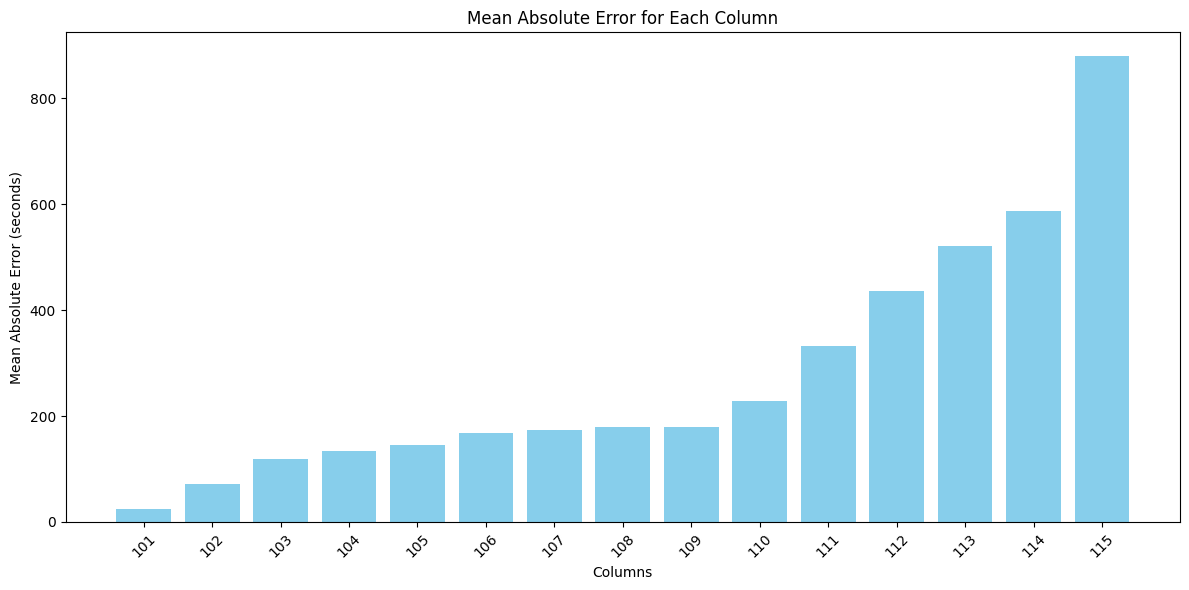

In [479]:
# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(mae_results.keys(), mae_results.values(), color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Mean Absolute Error (seconds)')
plt.title('Mean Absolute Error for Each Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

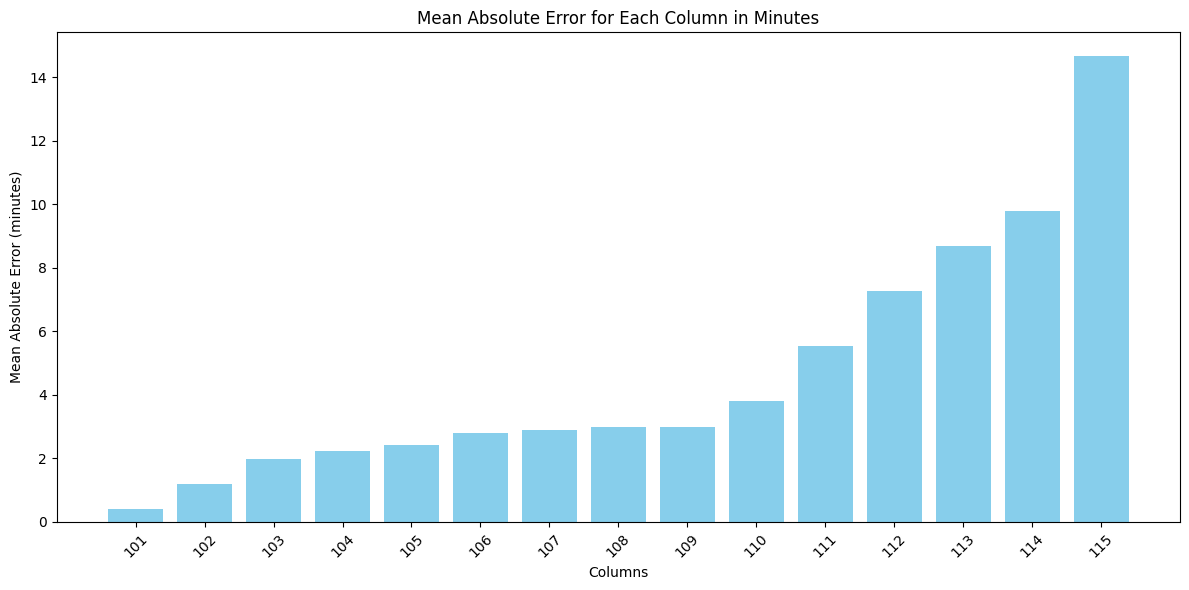

In [480]:
# Convert MAE from seconds to minutes
mae_results_minutes = {key: value / 60 for key, value in mae_results.items()}

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(mae_results_minutes.keys(), mae_results_minutes.values(), color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Mean Absolute Error (minutes)')
plt.title('Mean Absolute Error for Each Column in Minutes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [481]:
def generateMultistepPredictions(seg):
    predictions_list1 = []
    truedf = true_df.copy()
    # Loop through each row in final_df
    for index, row in final_df.iterrows():
        trip_id = row['trip_id']
        date = row['date']
        device_id = row['device_id']
        stops = ['start_time',101,102,103,104,105,106,107,108,109,110,111,112,113,114,'end_time']
        # Combine date and start time to form a datetime string
        datetime_str = f"{date} {row[stops[seg-1]]}"

        # Call the generatePredictions function
        predictions1 = generatePredictions(seg, datetime_str)

        # Add the trip_id, device_id, and predictions to the list
        predictions_list1.append([row['trip_id'], row['device_id']] + list(predictions1.values()))

    # Create a new dataframe with the predictions
    columns1 = ['trip_id', 'device_id'] + [f'{i+100}' for i in range(1, 16)]
    predictions_df1 = pd.DataFrame(predictions_list1, columns=columns1)
    predictions_df1.columns = predictions_df1.columns.astype(str)
    for k in range(seg-1):
        predictions_df1 = predictions_df1.drop(columns=[f'{k+101}'])
        truedf = truedf.drop(columns=[f'{k+101}'])
    predictions_df1 = predictions_df1.drop(columns=['trip_id','device_id'])
    return predictions_df1, truedf

In [482]:
p1,t1 = generateMultistepPredictions(10)

In [483]:
p1

,110,111,112,113,114,115
0,07:04:35,07:07:51,07:10:53,07:13:37,07:15:41,07:22:09
1,07:25:26,07:29:47,07:33:26,07:36:24,07:39:14,07:45:12
2,07:46:04,07:50:10,07:53:43,07:56:46,07:59:14,08:05:17
3,07:52:46,07:56:30,08:00:14,08:03:30,08:06:15,08:12:24
4,08:14:55,08:18:57,08:22:14,08:25:16,08:28:36,08:34:22
...,...,...,...,...,...,...
1407,16:39:36,16:43:06,16:45:55,16:48:46,16:50:59,16:56:44
1408,17:13:55,17:17:58,17:21:21,17:24:17,17:26:34,17:32:38
1409,17:30:11,17:34:44,17:38:27,17:41:22,17:43:47,17:49:56
1410,17:40:09,17:43:50,17:47:10,17:50:10,17:52:44,17:59:04


In [484]:
t1

,110,111,112,113,114,115
0,07:06:53,07:10:12,07:13:51,07:16:37,07:18:44,07:24:21
1,07:25:27,07:32:10,07:36:18,07:39:26,07:41:48,07:48:06
2,07:45:45,07:51:53,07:54:55,07:57:34,07:59:06,08:03:46
3,07:52:06,07:55:03,07:57:37,07:59:40,08:01:37,08:06:24
4,08:14:15,08:19:30,08:22:44,08:25:32,08:27:07,08:32:15
...,...,...,...,...,...,...
1410,16:38:59,16:41:31,16:44:18,16:46:32,16:52:53,16:59:30
1411,17:14:01,17:17:23,17:20:57,17:23:56,17:27:41,17:35:29
1412,17:31:14,17:35:24,17:38:55,17:41:24,17:43:24,17:49:28
1413,17:40:36,17:43:39,17:46:42,17:49:06,17:51:24,17:57:33


In [485]:
def getErrors(seg):
    # Calculate MAE for each column
    p1,t1 = generateMultistepPredictions(seg)
    mae_results1 = {}
    for col in t1.columns:
        mae = sum(time_difference_seconds(true, pred) for true, pred in zip(t1[col], p1[col])) / len(t1)
        mae_results1[col] = mae
    
    return mae_results1

In [486]:
getErrors(11)

{'111': 68.34985835694052,
 '112': 89.7514164305949,
 '113': 106.31232294617564,
 '114': 126.14943342776203,
 '115': 166.60906515580737}

In [487]:
def plot_error(seg):
    # Convert MAE from seconds to minutes
    mae_results_minutes = {key: value / 60 for key, value in getErrors(seg).items()}
    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(mae_results_minutes.keys(), mae_results_minutes.values(), color='skyblue')
    plt.xlabel('Columns')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title('Mean Absolute Error for Each Column in Minutes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

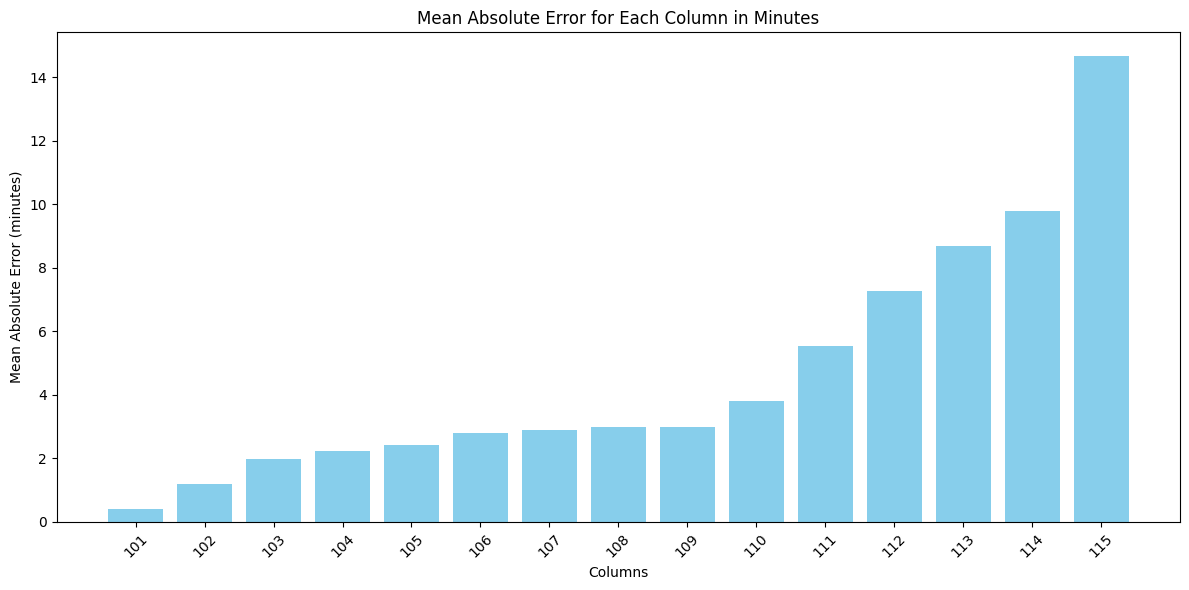

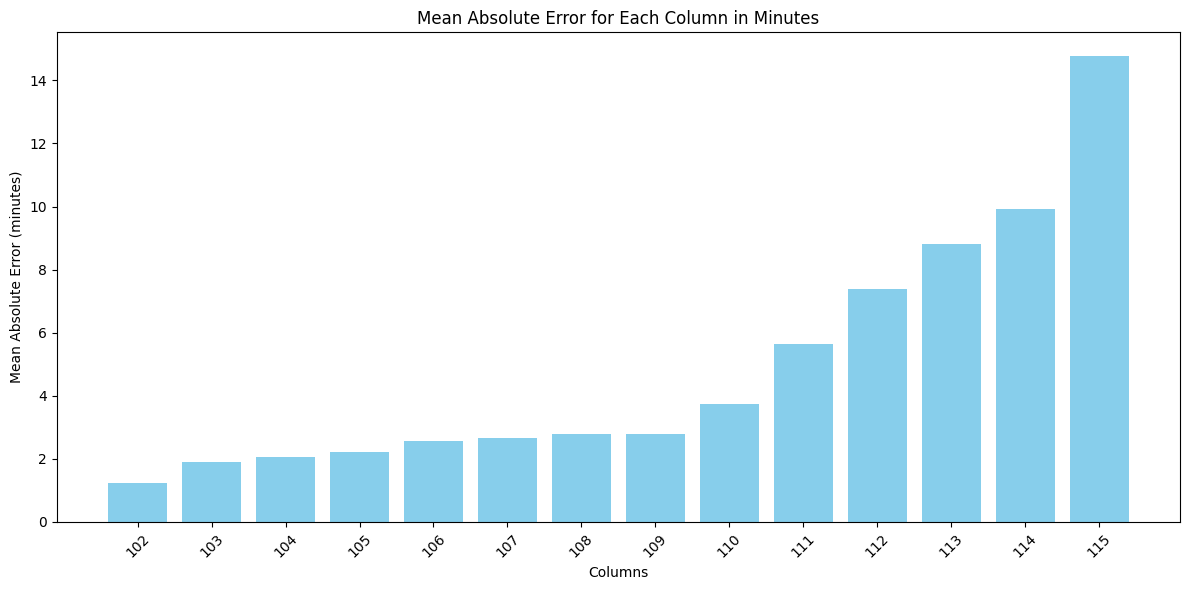

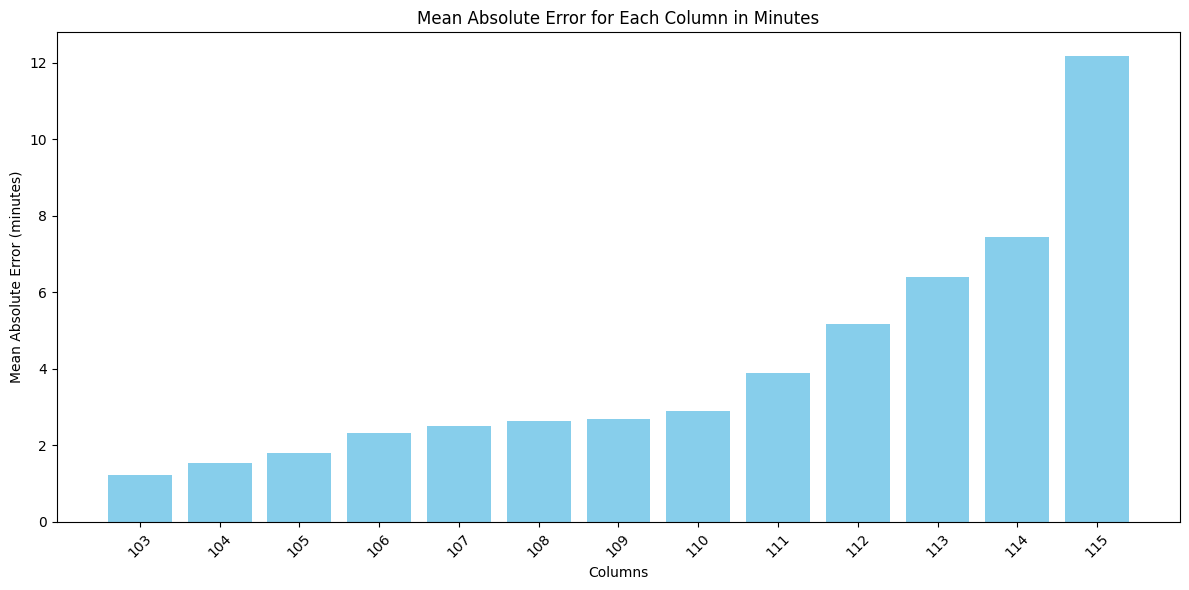

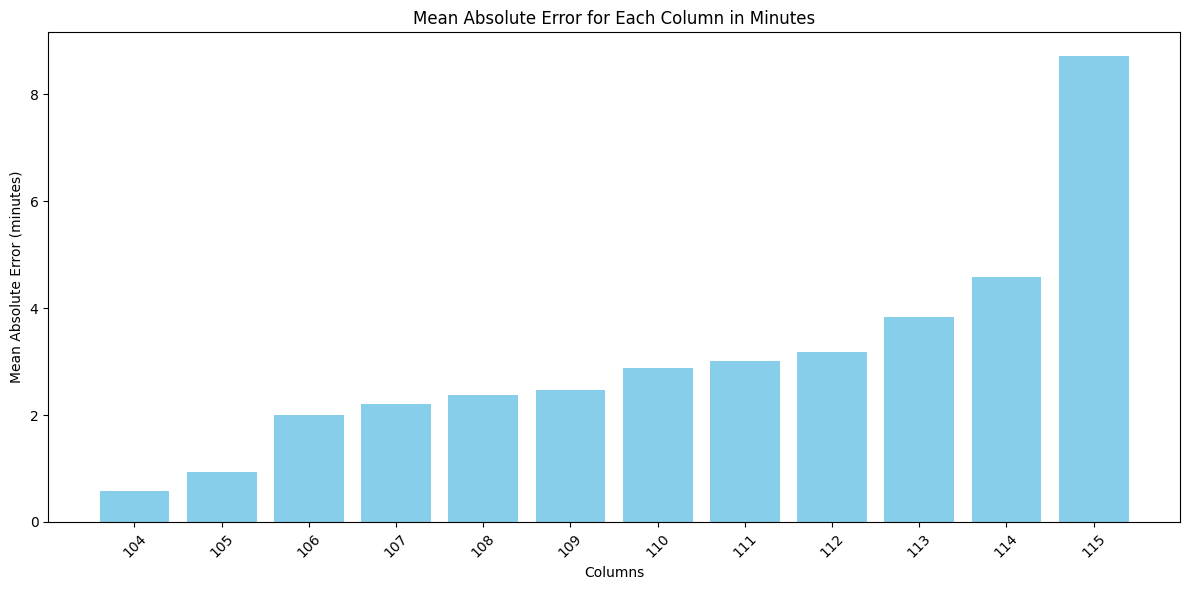

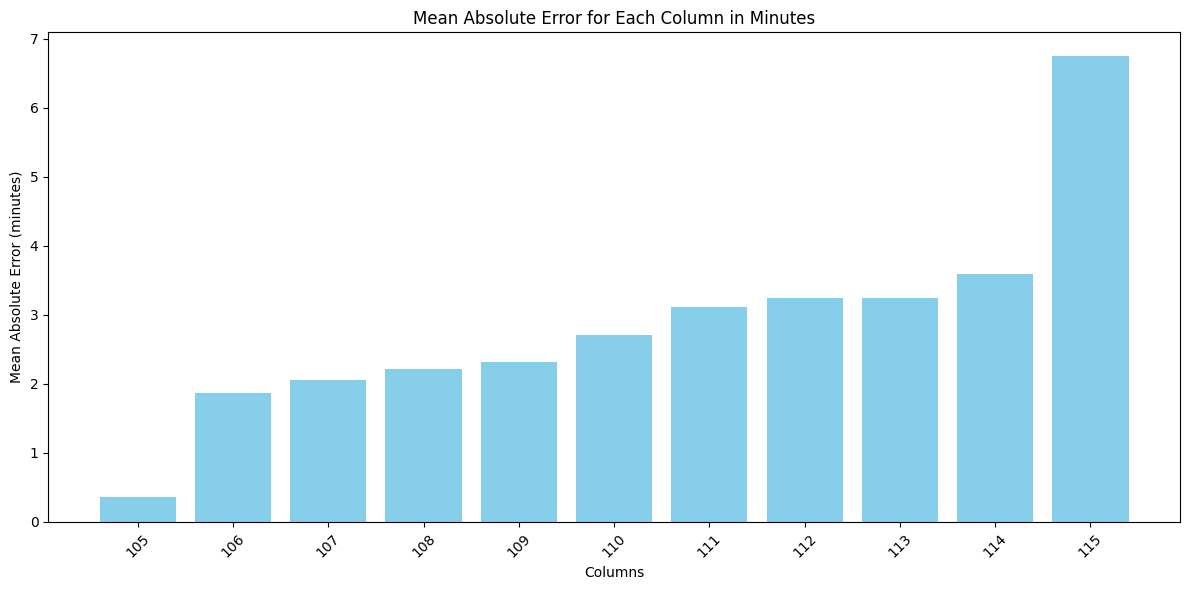

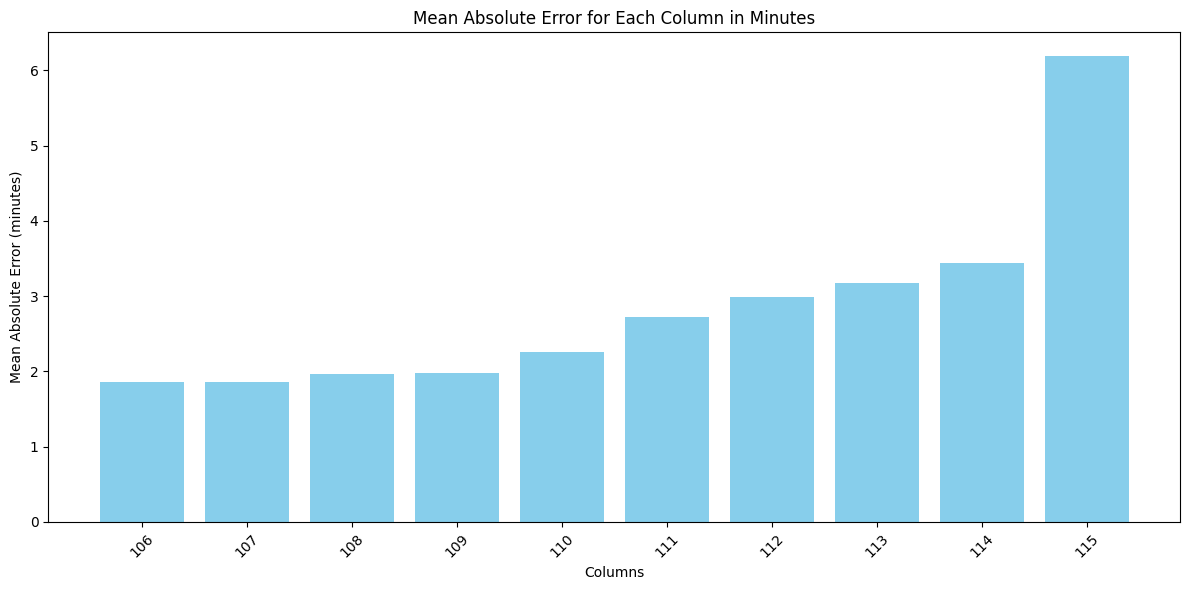

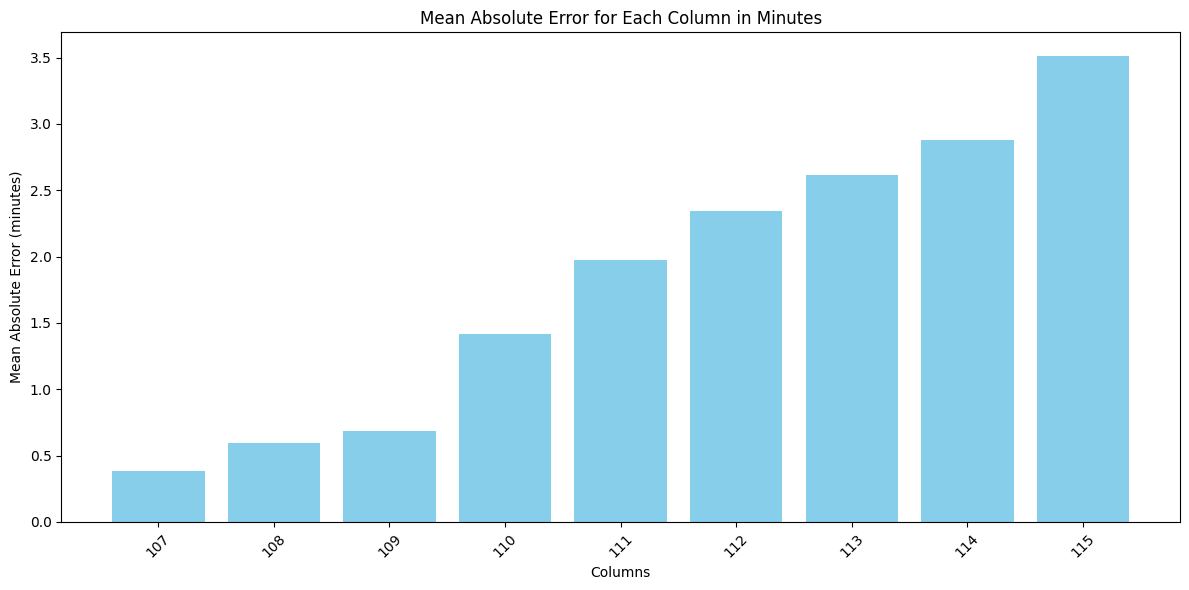

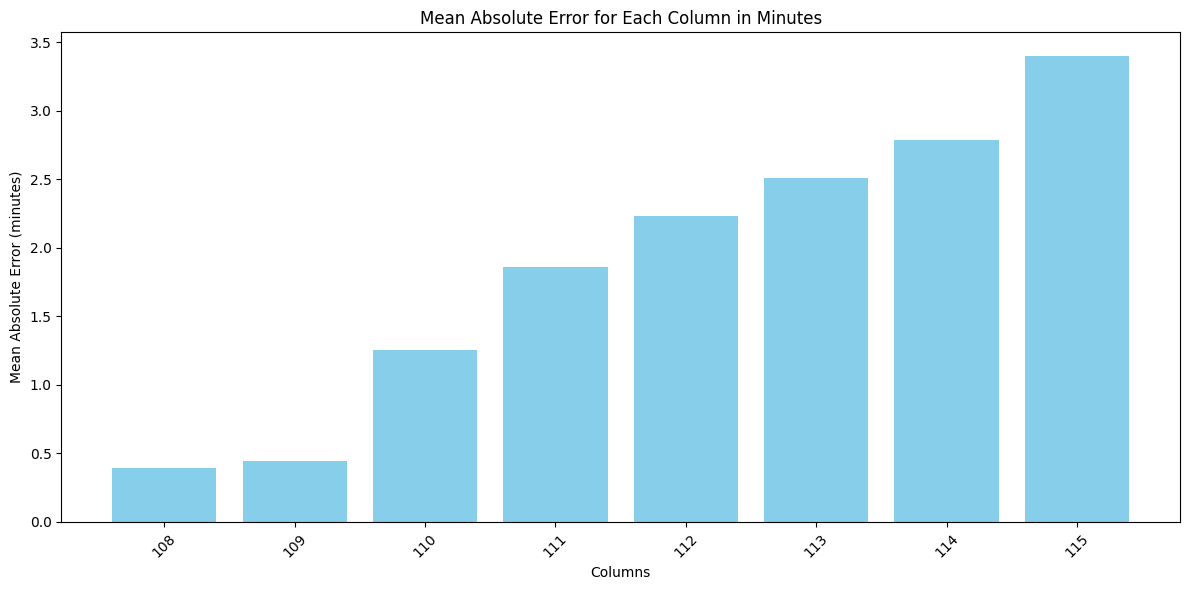

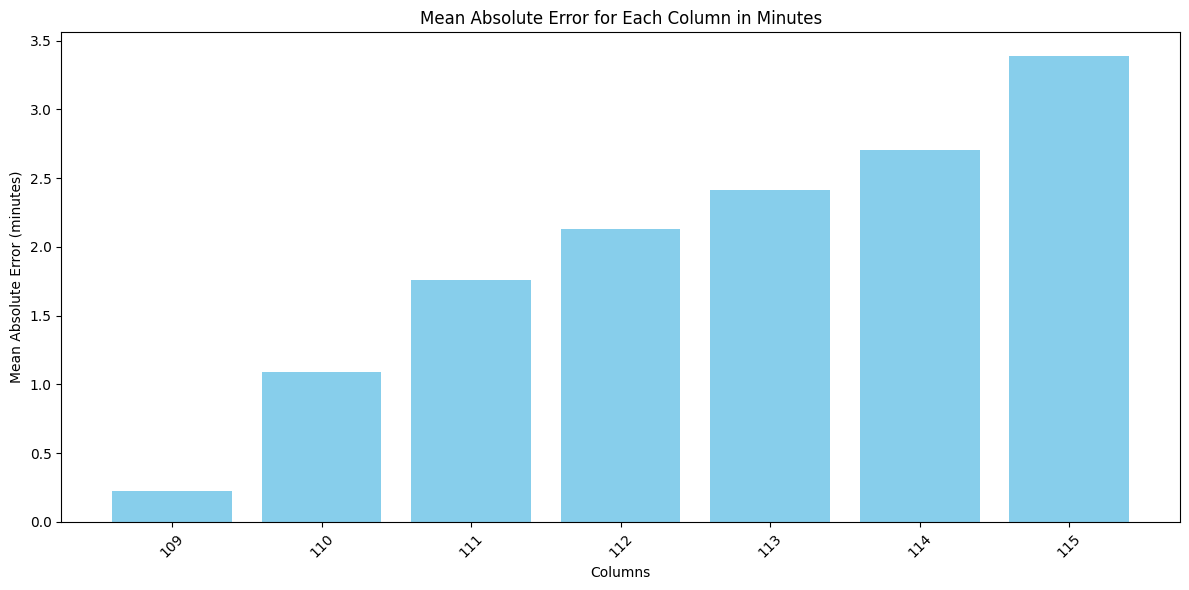

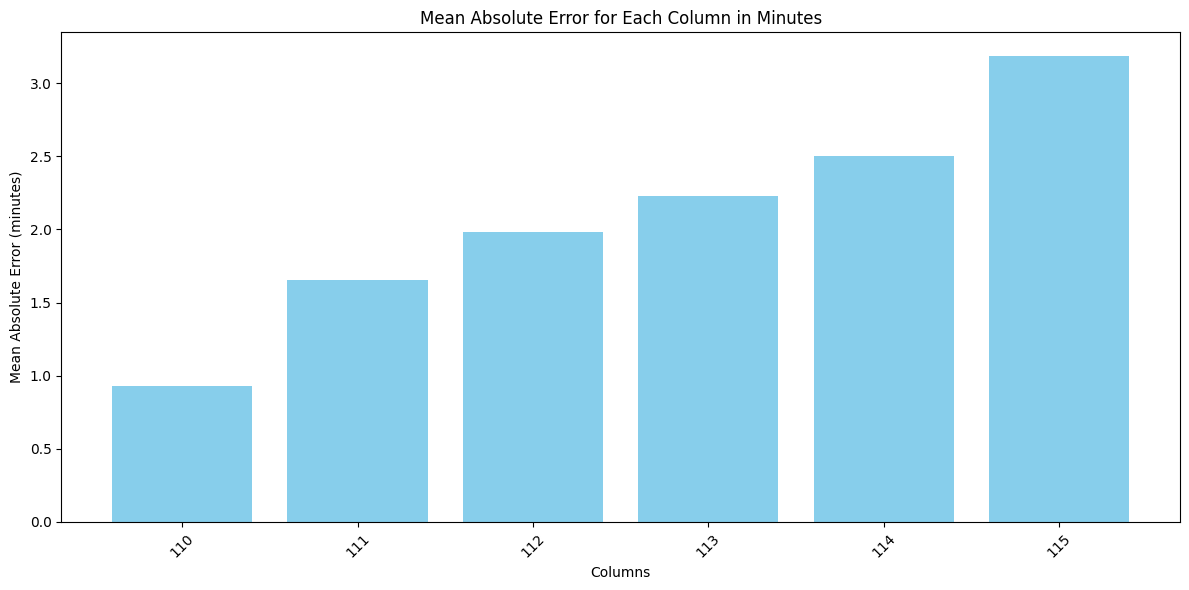

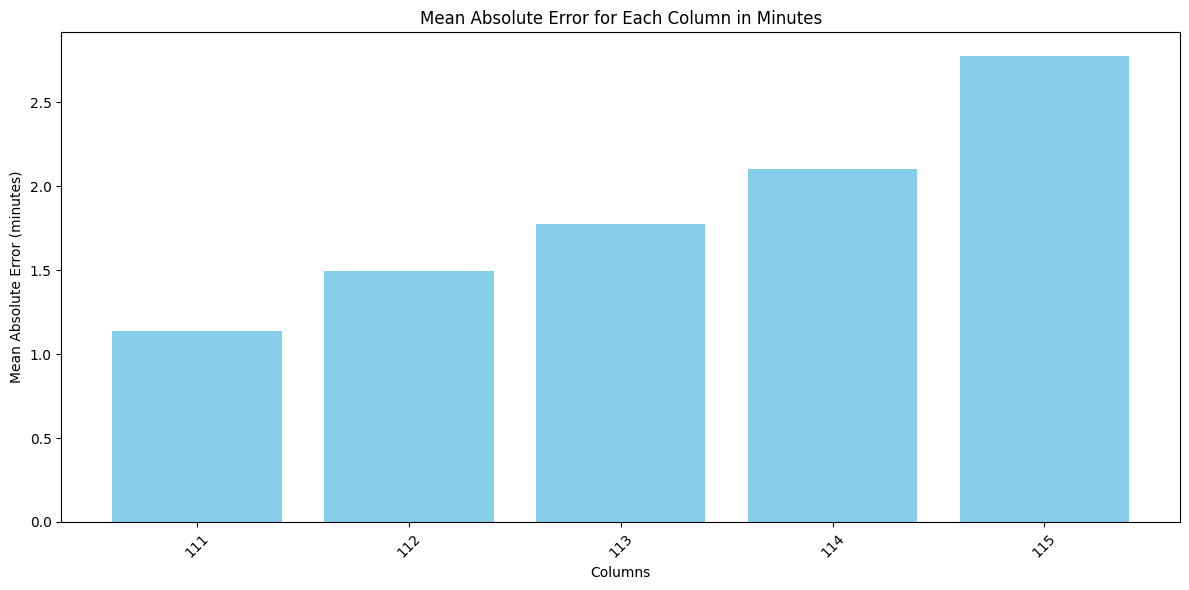

In [488]:
for i in range(1,12):
    plot_error(i)

In [489]:
final_result = [getErrors(i) for i in range(1,12)]

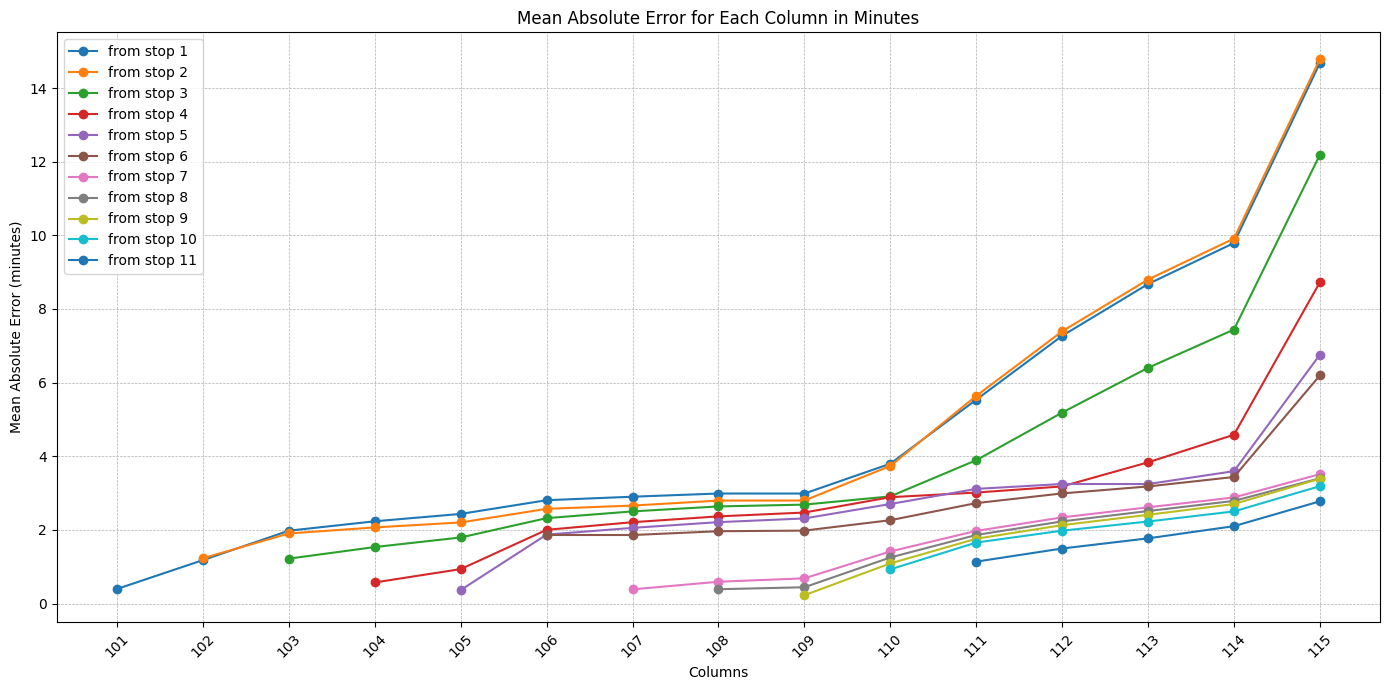

In [490]:
# Plotting
plt.figure(figsize=(14, 7))

for idx, res in enumerate(final_result, 1):
    x = list(res.keys())
    y = [value / 60 for value in res.values()]  # Convert to minutes
    plt.plot(x, y, label=f"from stop {idx}", marker='o')

plt.xlabel('Columns')
plt.ylabel('Mean Absolute Error (minutes)')
plt.title('Mean Absolute Error for Each Column in Minutes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

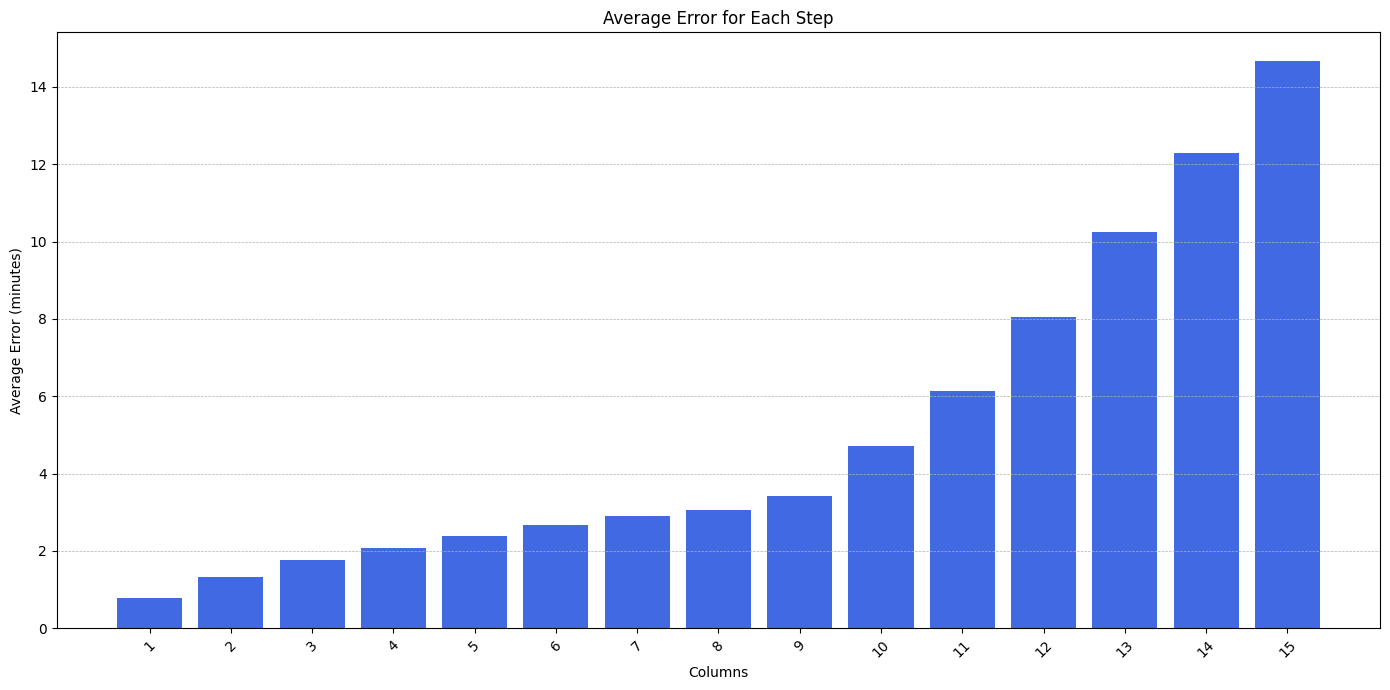

In [491]:
final_avg = dict()
for j in range(15):
    k = 11 if j < 5 else 15 - j
    temp = []
    for i in range(k):
        temp.append(final_result[i][str(i+101+j)])
    final_avg[j+1] = (sum(temp)/len(temp))/60

keys = list(final_avg.keys())
values = list(final_avg.values())

plt.figure(figsize=(14, 7))
plt.bar(keys, values, color='royalblue')
plt.xlabel('Columns')
plt.ylabel('Average Error (minutes)')  # Updated to 'minutes' since you divided the error by 60
plt.title('Average Error for Each Step')

# Set the xticks to show all keys
plt.xticks(keys, rotation=45)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.tight_layout()
plt.show()
